<a href="https://colab.research.google.com/github/serciex/lane-change/blob/main/PPO_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Prerequisites

In [1]:
!pip install pygame
!pip install highway-env

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 2.8 MB/s eta 0:00:00


Testing

In [2]:
#Import Libraries
from os import truncate
import math
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import pygame
import numpy as np


from IPython.display import Image, display
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
%matplotlib inline

Environment Definition

In [3]:
# Configure Environment Conditions
config = {
    "lanes_count": 3,
    "lane_width": 3.75,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy", "heading", "lat_off"]
    },
    "action": {"type": "ContinuousAction"},"ego_spawn_random": True,
    "policy_frequency": 10,
}
env = gymnasium.make('highway-v0', render_mode='rgb_array', config=config)
frames = []

# Action Setup
highway_env.envs.common.action.ContinuousAction(env, lateral=True,
                                                longitudinal=True)

In [4]:
# Environment Manager
class ENV(env.__class__):
  """
  s = (v,a,x,y,thetha,id,w,c) ∈ S

  Lateral Agent State:
  Obs Data:
  x = vehicle x position (x)
  y = vehicle y position (y)
  v = vehicle speed (vx)
  thetha = yaw angle (heading)

  Input:
  a = longitudinal acceleration (longitudinal_control)
  id = target lane id
  w = lane width
  c = road curvature

  Extra Data:
  vy = lateral rate (vy)
  delta_lat_deviation = change in lateral deviation (lat_off)

  """
  def __init__(self, obs,a):
    self.obs = obs
    self.a = a

  def ego_state_idm(self):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      self._ego_state_idm = {"x": ax, "y": ay, "vx": avx,"thetha": athetha,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_idm

  def ego_state_agent(self,target_id):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      vehicle = env.unwrapped.vehicle

      # Control Parameters
      self.id = target_id

      # Environment Parameters
      self.s,_ = vehicle.lane.local_coordinates(vehicle.position)
      self.w = vehicle.lane.width
      self.c = vehicle.lane.heading_at(np.clip(
          vehicle.lane.local_coordinates(vehicle.position)[0],
          0, vehicle.lane.length))
      self.v = math.sqrt(avx**2+avy**2)

      self._ego_state_agent = {"x": ax, "y": ay, "vx": self.v,"thetha": athetha,
                         "lane_width":self.w,"lane_id":self.id,
                         "self_curvature":self.c,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_agent

  def longitudinal_lead_state(self):
    # Lead State Parameters on the same Lane (5 columns: presence, x, y, vx, vy)
    ego_vehicle = env.unwrapped.vehicle
    lead_vehicle = env.unwrapped.road.neighbour_vehicles(ego_vehicle, lane_index=ego_vehicle.lane_index)[0]
    if lead_vehicle:
      gap = lead_vehicle.position[0] - ego_vehicle.position[0]
      delta_velocity = ego_vehicle.velocity[0] - lead_vehicle.velocity[0]
      self.longitudinal_lead_state = {"x": gap, "vx": delta_velocity}

    else:
      self.longitudinal_lead_state = {"x": 10, "vx": 0}

    return self.longitudinal_lead_state

  #Reward Function
  def reward_function(self, obs_old, obs_new, target_id, w1=1, w2=1, w3=0.05):
    """
    Reward Function:

    Acceleration Reward: r_acce = w1*f_acce(a_yaw)
    a_yaw = lateral acceleration (self.action)

    Rate Reward: r_rate = w2*f_rate(w_yaw)
    w_yaw = lateral rate (vy)

    Time Reward: r_time = w3*f_time (delta_lat_deviation)
    delta_lat_deviation = change in lateral deviation (self.lat_off)

    Reward = Cummulative Sum of r_acce + Cummulative Sum of r_rate + Cummulative Sum of r_time

    """

    self.target_id = ("0","1",target_id)
    target_lane_object = env.unwrapped.road.network.get_lane(self.target_id)
    vehicle_s, _ = env.unwrapped.vehicle.lane.local_coordinates(env.unwrapped.vehicle.position)
    _ , self.delta_lat_deviaton = target_lane_object.local_coordinates(env.unwrapped.vehicle.position)

    obs = obs_new[0]
    obs_old = obs_old[0]

    w_yaw = (obs[0] * obs[3] - obs[1] * obs[2]) / (obs[0]**2 + obs[1]**2 + 1e-8)
    w_yaw_old = (obs_old[0] * obs_old[3] - obs_old[1] * obs_old[2]) / (obs_old[0]**2 + obs_old[1]**2 + 1e-8)

    self.w_acce = (w_yaw-w_yaw_old)*env.unwrapped.config['policy_frequency']

    # Acceleration Reward
    acce_reward = -1*abs(self.w_acce)

    # Rate Reward
    rate_reward = -1*abs(w_yaw)

    # Time Reward
    time_reward = -0.05 * abs(self.delta_lat_deviaton)

    # Overall Reward
    self.reward = w1*acce_reward + w2*rate_reward + w3*time_reward

    return [self.reward, acce_reward, rate_reward, time_reward]

  #Acceleration to Steering angle
  def steering_angle(self, agent_action,L=1):
    """
    Steering Angle: theta = atan(a_yaw/v^2)
    a_yaw = lateral acceleration (agent_action)
    v = vehicle speed (vx)
    """
    self.angle = math.atan(L*agent_action/self.ego_state_idm()['vx']**2)

    return self.angle

Agent Defintion

In [5]:
class Agent(nn.Module):
  """
  s = (x, y, vx, vy, thetha, lane_width, lane_id, self_curvature, longitudinal_acceleration) ∈ S

  Lateral Agent State:
  x = vehicle x position
  y = vehicle y position
  vx = vehicle speed (longitudinal)
  thetha = yaw angle (heading)
  lane_width = width of the lane
  lane_id = target lane id
  self_curvature = road curvature at the vehicle's position
  longitudinal_acceleration = vehicle longitudinal acceleration
  """
  def __init__(self, state_dim, dim_1 = 100, dim_2 = 150):
    super(Agent, self).__init__()
    self.state_dim = state_dim
    # Define Network A & C
    self.networkA = nn.Sequential(
        nn.Linear(self.state_dim, dim_1),
        nn.Linear(dim_1, 1),
        nn.Softplus()
    )
    self.networkC = nn.Sequential(
        nn.Linear(self.state_dim + 1, dim_1),
        nn.ReLU(),
        nn.Linear(dim_1, 1),
    )

    # Define Network B
    self.networkB1 = nn.Sequential(
        nn.Linear(self.state_dim, dim_2),
        nn.ReLU(),
        nn.Linear(dim_2, 1),
    )
    self.networkB2 = nn.Sequential(
        nn.Linear(self.state_dim, dim_2),
        nn.ReLU(),
        nn.Linear(dim_2, 1),
    )
    self.networkB3 = nn.Sequential(
        nn.Linear(self.state_dim, dim_2),
        nn.ReLU(),
        nn.Linear(dim_2, 1),
    )

  def forward(self, state, a, terminal):
    """
    Q(s,a) = A(s)*(B(s)-a)^2 + C(s)
    """
    if isinstance(state, dict):
      state_tensor = torch.tensor(
          [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
          dtype=torch.float32
      ).unsqueeze(0)
    else:
        self.state = state
    # Use a directly if it's already a tensor
    self.a = a if isinstance(a, torch.Tensor) else torch.tensor([[a]], dtype=torch.float32)
    self.terminal_condition = terminal if isinstance(terminal, torch.Tensor) else torch.tensor([[terminal]], dtype=torch.float32)

    # Output of the Networks
    self.A = self.networkA(self.state)
    self.C = self.networkC(torch.concat((self.state, self.terminal_condition), dim=1))
    self.B = torch.max(self.networkB1(self.state) * self.networkB2(self.state),
                         self.networkB3(self.state))

    # Q-function Approximation
    q_value =self.A * ((self.B - self.a) ** 2) + self.C

    return q_value

  def action(self, state):
      # Convert it to a tensor
      if isinstance(state, dict):
          state_tensor = torch.tensor(
              [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
              dtype=torch.float32
          ).unsqueeze(0)
      else:
          state_tensor = state
      self.state = state_tensor
      self.B = torch.max(self.networkB1(self.state) * self.networkB2(self.state),
                         self.networkB3(self.state))
      return self.B

Experience Buffer

In [6]:
from collections import deque # Ensure imported

class Experience_Buffer():
    """
    Stores transitions as tuples of NumPy arrays (state_vec, action_vec, reward_vec, next_state_vec, terminal_vec).
    """
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=self.buffer_size)

    def add(self, state_vec, action, reward, next_state_vec, terminal_condition):
        state_np = np.asarray(state_vec, dtype=np.float32)
        next_state_np = np.asarray(next_state_vec, dtype=np.float32)
        action_np = np.asarray([action], dtype=np.float32)
        reward_np = np.asarray([reward], dtype=np.float32)
        terminal_np = np.asarray([float(terminal_condition)], dtype=np.float32)

        self.transition = (state_np, action_np, reward_np, next_state_np, terminal_np)
        self.buffer.append(self.transition)

    def sample_experience(self, batch_size, device):
        """ Samples batch and returns Tensors. """
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, terminals = zip(*batch)

        states_np = np.stack(states)
        actions_np = np.stack(actions)
        rewards_np = np.stack(rewards)
        next_states_np = np.stack(next_states)
        terminals_np = np.stack(terminals)

        # Convert final batch arrays to Tensors
        states_tensor = torch.tensor(states_np, dtype=torch.float32, device=device)
        actions_tensor = torch.tensor(actions_np, dtype=torch.float32, device=device)
        rewards_tensor = torch.tensor(rewards_np, dtype=torch.float32, device=device)
        next_states_tensor = torch.tensor(next_states_np, dtype=torch.float32, device=device)
        terminals_tensor = torch.tensor(terminals_np, dtype=torch.float32, device=device)

        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, terminals_tensor

    def size(self):
        return len(self.buffer)

Lateral Controller (Gap Checker)

In [7]:
import numpy as np

class Gap_Controller(env.__class__):
    def __init__(self, obs=None, following_gap_threshold=10.0):
        # Optionally store an initial observation if provided.
        if obs is not None:
            self.obs = obs
        # Threshold for safety gap with the following vehicle
        self.following_gap_threshold = following_gap_threshold

    def lane_checker(self):
        """
        Determines which adjacent lane offers the safest gap for a lane change.
        It examines the current lane, the lane to the left, and the lane to the right,
        returning the lane index that has the largest safe front gap available.
        In addition, if the gap with the following vehicle in the target lane is below the safety
        threshold, the lane change is aborted and the current lane is chosen.

        Returns:
            int: The target lane index (the lane with the largest safe gap, or the current lane)
                 if the candidate lane's following vehicle gap is unsafe.
        """
        lane_number = len(env.unwrapped.road.network.lanes_list())
        ego = env.unwrapped.vehicle

        # Initialize front gap values with a default that indicates an unsafe or non-existent gap.
        gap_current_front = -float('inf')
        gap_right_front = -float('inf')
        gap_left_front = -float('inf')

        # Initialize following gap values (gap between ego and the vehicle behind)
        gap_current_follower = float('inf')
        gap_right_follower = float('inf')
        gap_left_follower = float('inf')

        # Get vehicle neighbours in current lane:
        neighbours_current = env.unwrapped.road.neighbour_vehicles(ego, ego.lane_index)
        # neighbours_current[0] is the vehicle ahead and [1] is the following vehicle.
        if neighbours_current:
            if neighbours_current[0]:
                gap_current_front = neighbours_current[0].position[0] - ego.position[0]
            if len(neighbours_current) > 1 and neighbours_current[1]:
                gap_current_follower = ego.position[0] - neighbours_current[1].position[0]

        # Compute the left and right lane indices.
        current_lane = list(ego.lane_index)
        if current_lane[2] > 0:
            lane_left = (current_lane[0], current_lane[1], current_lane[2] - 1)
        else:
            lane_left = ego.lane_index

        if current_lane[2] < (lane_number - 1):
            lane_right = (current_lane[0], current_lane[1], current_lane[2] + 1)
        else:
            lane_right = ego.lane_index

        # Retrieve neighbour vehicles for the right lane.
        neighbours_right = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_right)
        if neighbours_right:
            if neighbours_right[0]:
                gap_right_front = neighbours_right[0].position[0] - ego.position[0]
            if len(neighbours_right) > 1 and neighbours_right[1]:
                gap_right_follower = ego.position[0] - neighbours_right[1].position[0]

        # Retrieve neighbour vehicles for the left lane.
        neighbours_left = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_left)
        if neighbours_left:
            if neighbours_left[0]:
                gap_left_front = neighbours_left[0].position[0] - ego.position[0]
            if len(neighbours_left) > 1 and neighbours_left[1]:
                gap_left_follower = ego.position[0] - neighbours_left[1].position[0]

        # Compare the front gaps: current, right, and left.
        front_gaps = [gap_current_front, gap_right_front, gap_left_front]
        best_index = np.argmax(front_gaps)

        # Determine the target lane index based on the best candidate.
        # best_index: 0 => current lane, 1 => right lane, 2 => left lane.
        if best_index == 1:
            candidate_lane = lane_right
            candidate_follower_gap = gap_right_follower
        elif best_index == 2:
            candidate_lane = lane_left
            candidate_follower_gap = gap_left_follower
        else:
            candidate_lane = ego.lane_index
            candidate_follower_gap = gap_current_follower  # in current lane, we don't enforce follower gap condition

        # Check if the candidate lane (if different from the current lane)
        # meets the follower gap condition.
        if candidate_lane != ego.lane_index:
            if candidate_follower_gap < self.following_gap_threshold:
                # The follower gap is too small; do not change lanes.
                target_lane_id = ego.lane_index[2]
            else:
                target_lane_id = candidate_lane[2]
        else:
            target_lane_id = ego.lane_index[2]

        return target_lane_id


Longitudinal Controller

In [8]:
class IDM():
    ''' Intelligent Driving Model for Longitudinal Control

    Control parameters:
      a: maximum acceleration
      b: comfortable deceleration
      delta: acceleration exponent
      T: safe time headway

    Parameters:
      s0: minimum gap
      v0: desired speed

      a (Maximum Acceleration): How fast the vehicle can speed up (m/s²).
      b (Comfortable Deceleration): How smoothly the vehicle slows down (m/s²).
      δ (Acceleration Exponent): The non-linearity factor in acceleration.
      T (Safe Time Headway): The desired minimum following time gap (s).

    Input variables:
      s: current gap
      v: current vehicle speed
      delta_v: relative speed (difference between the vehicle's speed and the leading vehicle's speed)
    '''

    def __init__(self, desired_parameters, control_parameters):
        # Unpack initial parameters: [s0, v0]
        self.s0, self.v0 = desired_parameters
        # Unpack control parameters: [a, b, delta, T]
        self.a, self.b, self.delta, self.T = control_parameters

    def longitudinal_controller(self, input_variables):
        # Unpack input variables: [s, v, delta_v]
        s, v, delta_v = input_variables

        # Small epsilon to account for very small gaps and avoid division by zero
        epsilon = 1e-6

        # Desired gap: s* = s0 + v*T + (v * delta_v) / (2 * sqrt(a * b))
        desired_gap = self.s0 + max(0, v * self.T + ((v * delta_v) / (2 * math.sqrt(self.a * self.b))))

        # IDM acceleration: a_IDM = a * [ 1 - (v / v0)^delta - (s* / s)^2 ]
        acceleration = self.a * (1 - (v / self.v0)**self.delta - (desired_gap / (s + epsilon))**2)

        return acceleration

State Normalization

In [9]:
import numpy as np
import torch

# --- Define these globally or pass them to the normalizer ---
# MUST match the order expected by the Agent input and feature extraction
STATE_KEYS_ORDER = ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha',
                    'lane_id', 'lane_width', 'self_curvature']
STATE_DIM = len(STATE_KEYS_ORDER)
# ---------------------------------------------------------

class StateNormalizer:
    """
    Computes running mean and standard deviation for state normalization (Z-score).
    Uses Welford's online algorithm for numerical stability.
    Includes methods to handle dictionary inputs.
    """
    def __init__(self, size=STATE_DIM, epsilon=1e-5, clip_range=5.0, device='cpu'):
        """
        Initializes the normalizer.

        Args:
            size (int): The dimension of the state vector (should match STATE_DIM).
            epsilon (float): Small value to prevent division by zero in std dev.
            clip_range (float): Range [-clip_range, clip_range] to clip normalized states.
            device (str or torch.device): The device to put output tensors on.
        """
        if size != STATE_DIM:
            raise ValueError(f"Normalizer size ({size}) does not match expected STATE_DIM ({STATE_DIM})")
        self.size = size
        self.epsilon = epsilon
        self.clip_range = clip_range
        self.device = torch.device(device) # Store device

        # Welford's algorithm variables
        self.count = 0
        self.mean = np.zeros(self.size, dtype=np.float32)
        self.M2 = np.zeros(self.size, dtype=np.float32)

    def _state_dict_to_vector(self, state_dict):
        """Converts the state dictionary to a NumPy vector."""
        # Internal helper, could also be a static method or defined outside
        if state_dict is None:
            # Return zeros or raise error? Let's return zeros for now.
            print("Warning: Received None state_dict, returning zero vector.")
            return np.zeros(self.size, dtype=np.float32)
        try:
            # Ensure all keys exist before list comprehension
            for key in STATE_KEYS_ORDER:
                if key not in state_dict:
                    raise KeyError(f"Missing key '{key}'")
            state_vector = np.array([state_dict[key] for key in STATE_KEYS_ORDER], dtype=np.float32)
            return state_vector
        except KeyError as e:
            raise KeyError(f"Missing key {e} in state dictionary for normalization. Available keys: {list(state_dict.keys())}")
        except Exception as e:
            raise ValueError(f"Error converting state dict to vector: {e}")

    def update_from_dict(self, state_dict):
        """
        Updates the running mean and M2 using a new state dictionary.

        Args:
            state_dict (dict): A single state dictionary.
        """
        state_vector = self._state_dict_to_vector(state_dict)
        # Now use the existing update logic with the vector
        self.count += 1
        delta = state_vector - self.mean
        self.mean += delta / self.count
        delta2 = state_vector - self.mean
        self.M2 += delta * delta2

    def _get_stddev(self):
        """Calculates the current standard deviation."""
        if self.count < 2:
            return np.ones(self.size, dtype=np.float32)
        variance = self.M2 / (self.count -1) # Sample variance
        stddev = np.sqrt(np.maximum(variance, self.epsilon**2)) # Use epsilon^2 with sqrt
        # Ensure stddev is not exactly zero
        stddev = np.maximum(stddev, self.epsilon)
        return stddev

    def normalize_dict_to_tensor(self, state_dict):
        """
        Converts a state dictionary to a NumPy vector, normalizes it,
        clips it, and returns it as a Tensor on the specified device.
        Does NOT update running statistics.

        Args:
            state_dict (dict): The state dictionary to normalize.

        Returns:
            torch.Tensor: The normalized state as a Tensor [1, state_dim].
        """
        state_vector = self._state_dict_to_vector(state_dict)

        mean_tensor = torch.tensor(self.mean, dtype=torch.float32, device=self.device)
        stddev_tensor = torch.tensor(self._get_stddev(), dtype=torch.float32, device=self.device)
        state_tensor = torch.tensor(state_vector, dtype=torch.float32, device=self.device)

        # Normalize: (state - mean) / stddev
        normalized_tensor = (state_tensor - mean_tensor) / stddev_tensor

        # Clip and add batch dimension
        clipped_tensor = torch.clamp(normalized_tensor, -self.clip_range, self.clip_range).unsqueeze(0)

        return clipped_tensor

    def normalize_batch_tensor(self, state_batch_tensor):
        """
        Normalizes a batch of state vectors already in Tensor format.
        Used during learning update after sampling from buffer.
        Does NOT update running statistics.

        Args:
            state_batch_tensor (torch.Tensor): Batch of state vectors [batch_size, state_dim].

        Returns:
            torch.Tensor: The normalized batch of states, clipped.
        """
        if not isinstance(state_batch_tensor, torch.Tensor):
             state_batch_tensor = torch.tensor(state_batch_tensor, dtype=torch.float32, device=self.device)

        mean_tensor = torch.tensor(self.mean, dtype=torch.float32, device=self.device)
        stddev_tensor = torch.tensor(self._get_stddev(), dtype=torch.float32, device=self.device)

        # Ensure tensors are on the same device as the input batch
        mean_tensor = mean_tensor.to(state_batch_tensor.device)
        stddev_tensor = stddev_tensor.to(state_batch_tensor.device)

        # Normalize: (batch_state - mean) / stddev (broadcasting applies)
        normalized_batch = (state_batch_tensor - mean_tensor) / stddev_tensor

        # Clip
        clipped_batch = torch.clamp(normalized_batch, -self.clip_range, self.clip_range)

        return clipped_batch

    # --- Optional: Load/Save ---
    def get_state(self):
        return {'count': self.count, 'mean': self.mean.tolist(), 'M2': self.M2.tolist()} # Save as lists

    def set_state(self, state_dict):
        self.count = state_dict['count']
        self.mean = np.array(state_dict['mean'], dtype=np.float32)
        self.M2 = np.array(state_dict['M2'], dtype=np.float32)

Initialize Environment

In [10]:
# Initialize Environment
obs, _ = env.reset()

# Initialize Environment Manager and Reward
state_manager = ENV(obs,obs[0][2])

# State Manager for Ego and Lead State
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()

# Initial Longitundinal Positions
ego_position_idm = ego_state_idm['x']
lead_position_idm = lead_state['x']

# Initial Velocities (using vx for longitudinal control)
ego_velocity_idm = ego_state_idm['vx']
lead_velocity_idm = lead_state['vx']

PPO Agent (Alternative)

In [16]:
"""PPO Agent Implementation with Fixed Device Handling

This implementation ensures that all tensors are on the same device (CPU or GPU)
to avoid the "Expected all tensors to be on the same device" error.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.distributions import Normal

class PPOAgent(nn.Module):
    """
    PPO Agent implementing an actor-critic architecture.
    - Actor: Policy network that outputs action mean and standard deviation
    - Critic: Value network that estimates the state value
    """
    def __init__(self, state_dim, action_dim=1, hidden_dim=64, action_std_init=0.6,
                 action_clip=1.0, device='cpu'):
        super(PPOAgent, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device
        self.action_clip = action_clip  # Action clipping range (-action_clip, action_clip)

        # Initialize log of action std deviation - make sure it's on the correct device
        self.action_log_std = nn.Parameter(torch.ones(action_dim, device=device) * np.log(action_std_init))

        # Actor Network (Policy)
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()  # Use Tanh to bound actions in [-1, 1]
        )

        # Critic Network (Value Function)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Explicitly move networks to the specified device
        self.actor = self.actor.to(device)
        self.critic = self.critic.to(device)

    def forward(self):
        # Just to satisfy nn.Module requirements
        raise NotImplementedError

    def act(self, state, deterministic=False):
        """
        Use the actor to get an action and its log probability

        Args:
            state: Current state tensor
            deterministic: If True, return the mean action without sampling

        Returns:
            action: Selected action
            action_log_prob: Log probability of the selected action
            value: Value of the state estimated by the critic
        """
        if isinstance(state, dict):
            # Convert dictionary state to tensor for use with the actor
            state_values = [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y',
                                                 'thetha', 'lane_id', 'lane_width', 'self_curvature']]
            state_tensor = torch.tensor(state_values, dtype=torch.float32, device=self.device).unsqueeze(0)
        elif isinstance(state, np.ndarray):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        else:
            # Ensure the tensor is on the correct device
            state_tensor = state.to(self.device)

        # Get mean action from the actor
        action_mean = self.actor(state_tensor)

        # Get state value from the critic
        value = self.critic(state_tensor)

        # In deterministic mode, return mean action
        if deterministic:
            return action_mean.detach(), None, value.detach()

        # Sample from the distribution
        action_std = torch.exp(self.action_log_std).to(action_mean.device).expand_as(action_mean)
        dist = Normal(action_mean, action_std)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)

        # Clip action to the valid range
        action_clipped = torch.clamp(action, -self.action_clip, self.action_clip)

        return action_clipped.detach(), action_log_prob.detach(), value.detach()

    def evaluate(self, state, action):
        """
        Evaluate a state-action pair

        Args:
            state: State tensor
            action: Action tensor

        Returns:
            value: State value
            action_log_probs: Log probability of the action
            dist_entropy: Entropy of the action distribution
        """
        # Ensure inputs are on the correct device
        state = state.to(self.device)
        action = action.to(self.device)

        # Get mean action from the actor
        action_mean = self.actor(state)

        # Get state value from the critic
        value = self.critic(state)

        # Get the action distribution - ensure same device
        action_std = torch.exp(self.action_log_std).to(action_mean.device).expand_as(action_mean)
        dist = Normal(action_mean, action_std)

        # Calculate log probability and entropy
        action_log_probs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        return value, action_log_probs, dist_entropy

    def set_action_std(self, new_action_std):
        """
        Update the action standard deviation

        Args:
            new_action_std: New value for action std
        """
        self.action_log_std.data = torch.log(torch.ones(self.action_dim, device=self.device) * new_action_std)

class PPOTrainer:
    """
    PPO Trainer to handle the training process
    """
    def __init__(self, agent, lr=0.0003, gamma=0.99, eps_clip=0.2,
                 k_epochs=4, value_coef=0.5, entropy_coef=0.01):
        """
        Initialize the PPO trainer

        Args:
            agent: PPO agent to train
            lr: Learning rate
            gamma: Discount factor
            eps_clip: PPO clip parameter
            k_epochs: Number of optimization epochs per update
            value_coef: Value loss coefficient
            entropy_coef: Entropy coefficient for exploration
        """
        self.agent = agent
        self.lr = lr
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef

        self.optimizer = optim.Adam(self.agent.parameters(), lr=lr)

    def update(self, states, actions, log_probs, returns, advantages):
        """
        Update policy and value parameters using PPO

        Args:
            states: Batch of states
            actions: Batch of actions
            log_probs: Batch of log probabilities from the old policy
            returns: Batch of estimated returns
            advantages: Batch of advantages

        Returns:
            loss_info: Dictionary with loss statistics
        """
        # Get device from agent
        device = self.agent.device

        # Convert to tensors with correct shapes, ensuring they're on the right device
        states = torch.tensor(states, dtype=torch.float32, device=device)
        old_actions = torch.tensor(actions, dtype=torch.float32, device=device).unsqueeze(1)
        old_log_probs = torch.tensor(log_probs, dtype=torch.float32, device=device).unsqueeze(1)
        returns = torch.tensor(returns, dtype=torch.float32, device=device).unsqueeze(1)
        advantages = torch.tensor(advantages, dtype=torch.float32, device=device)

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        loss_info = {
            'value_loss': [],
            'policy_loss': [],
            'entropy': [],
            'total_loss': []
        }

        # PPO update for k epochs
        for _ in range(self.k_epochs):
            # Get current evaluations
            values, log_probs, entropy = self.agent.evaluate(states, old_actions)

            # Calculate ratios and surrogate losses
            ratios = torch.exp(log_probs - old_log_probs.detach())
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # Calculate losses
            value_loss = F.mse_loss(values, returns)
            policy_loss = -torch.min(surr1, surr2).mean()
            entropy_loss = -entropy.mean()

            # Combine losses
            loss = policy_loss + self.value_coef * value_loss + self.entropy_coef * entropy_loss

            # Store loss info
            loss_info['value_loss'].append(value_loss.item())
            loss_info['policy_loss'].append(policy_loss.item())
            loss_info['entropy'].append(entropy_loss.item())
            loss_info['total_loss'].append(loss.item())

            # Update parameters
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Return average losses
        for key in loss_info:
            loss_info[key] = np.mean(loss_info[key])

        return loss_info

    @staticmethod
    def compute_gae(rewards, values, dones, next_value, gamma=0.99, gae_lambda=0.95):
        """
        Compute Generalized Advantage Estimation (GAE)

        Args:
            rewards: Array of rewards
            values: Array of state values
            dones: Array of done flags
            next_value: Value of the next state
            gamma: Discount factor
            gae_lambda: GAE lambda parameter

        Returns:
            advantages: GAE advantages
            returns: Estimated returns
        """
        advantages = np.zeros_like(rewards)
        last_gae_lam = 0

        # Flatten values if they're 2D
        if isinstance(values, np.ndarray) and len(values.shape) > 1:
            values = values.flatten()
        elif isinstance(values, torch.Tensor):
            values = values.cpu().numpy().flatten()

        # Create array of values including the next state value
        # If next_value is a tensor, convert to numpy
        if isinstance(next_value, torch.Tensor):
            next_value = next_value.cpu().item()

        values_extended = np.append(values, next_value)

        # Iterate in reverse to calculate GAE
        for t in reversed(range(len(rewards))):
            # If done, reset the value
            if dones[t]:
                next_val = 0
            else:
                next_val = values_extended[t + 1]

            # Calculate TD error
            delta = rewards[t] + gamma * next_val - values_extended[t]

            # Calculate GAE
            advantages[t] = last_gae_lam = delta + gamma * gae_lambda * (1 - dones[t]) * last_gae_lam

        # Calculate returns
        returns = advantages + values

        return advantages, returns

class PPOMemory:
    """
    Memory buffer for PPO
    """
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
        self.values = []

    def add(self, state, action, reward, done, log_prob, value):
        """
        Add a transition to the memory
        """
        if isinstance(state, dict):
            # Extract values from state dictionary
            state_values = [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y',
                                               'thetha', 'lane_id', 'lane_width', 'self_curvature']]
            self.states.append(np.array(state_values, dtype=np.float32))
        elif isinstance(state, torch.Tensor):
            self.states.append(state.cpu().numpy().flatten())
        else:
            self.states.append(state)

        # Handle the case where tensor values are on GPU
        if isinstance(action, torch.Tensor):
            action = action.cpu().item()
        if isinstance(log_prob, torch.Tensor):
            log_prob = log_prob.cpu().item()
        if isinstance(value, torch.Tensor):
            value = value.cpu().item()

        self.actions.append(action)
        self.rewards.append(reward)
        self.dones.append(done)
        self.log_probs.append(log_prob)
        self.values.append(value)

    def clear(self):
        """
        Clear the memory after an update
        """
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
        self.values = []

    def size(self):
        """
        Return the size of the memory buffer
        """
        return len(self.states)

    def get_all(self):
        """
        Get all stored data
        """
        return (
            np.array(self.states),
            np.array(self.actions),
            np.array(self.rewards),
            np.array(self.dones),
            np.array(self.log_probs),
            np.array(self.values)
        )

Training Loop

Always Active (Option 1)

Using device: cuda
Starting PPO training loop...
Device: cuda, Update Timestep: 1024
Learning Rate: 0.0003, Gamma: 0.99, GAE Lambda: 0.95
PPO Clip: 0.2, Value Coef: 0.5, Entropy Coef: 0.01
K Epochs: 10, Action STD: 0.6
Max Timesteps: 40000, Episode Max Length: 200
Ep   1 | Steps:    3 | Avg Ep Len: 3.0 | Total Steps:     3/40000 | Ep Return:  -2.51 | Avg Return:  -2.51 | Reward/Step: -0.837±0.108 | Action STD: 0.600
Ep   2 | Steps:    3 | Avg Ep Len: 3.0 | Total Steps:     6/40000 | Ep Return:  -2.51 | Avg Return:  -2.51 | Reward/Step: -0.837±0.108 | Action STD: 0.600
Ep   3 | Steps:    3 | Avg Ep Len: 3.0 | Total Steps:     9/40000 | Ep Return:  -2.53 | Avg Return:  -2.52 | Reward/Step: -0.844±0.107 | Action STD: 0.600
Ep   4 | Steps:   12 | Avg Ep Len: 5.2 | Total Steps:    21/40000 | Ep Return:  -8.90 | Avg Return:  -4.11 | Reward/Step: -0.742±0.069 | Action STD: 0.600
Ep   5 | Steps:    8 | Avg Ep Len: 5.8 | Total Steps:    29/40000 | Ep Return:  -4.37 | Avg Return:  -4.16 | Reward

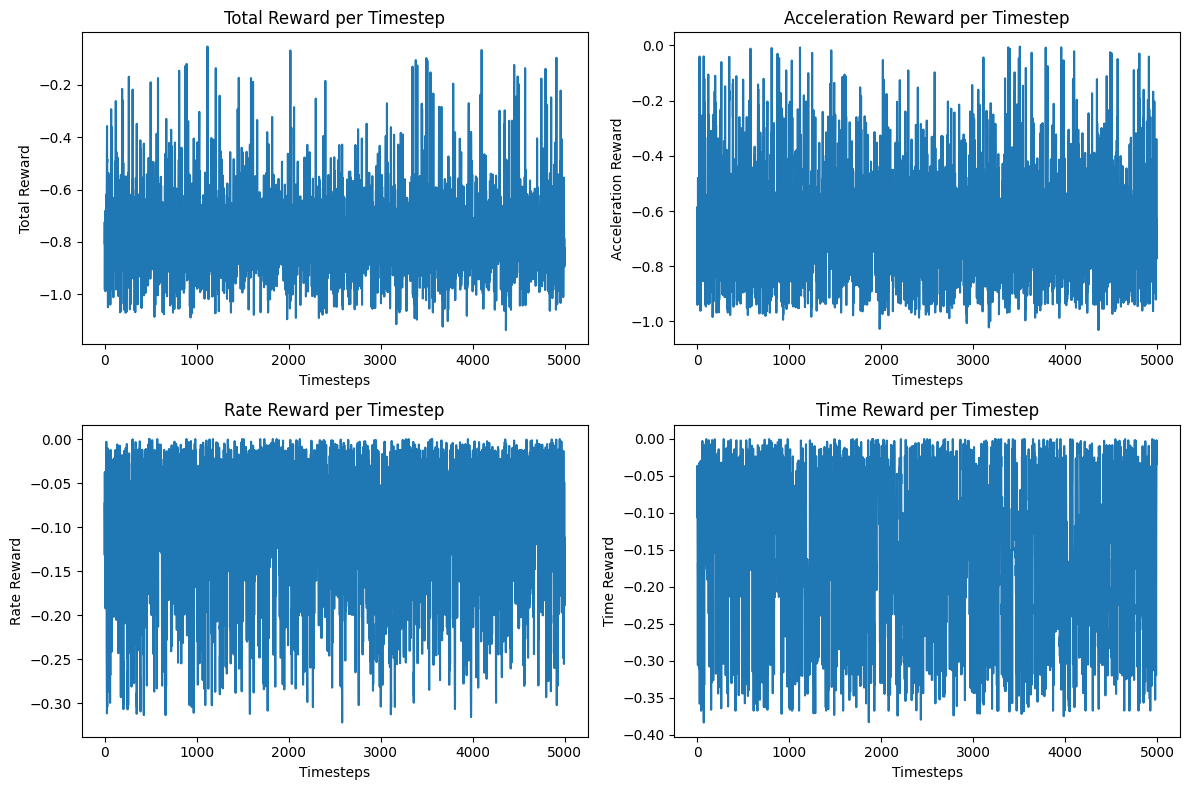

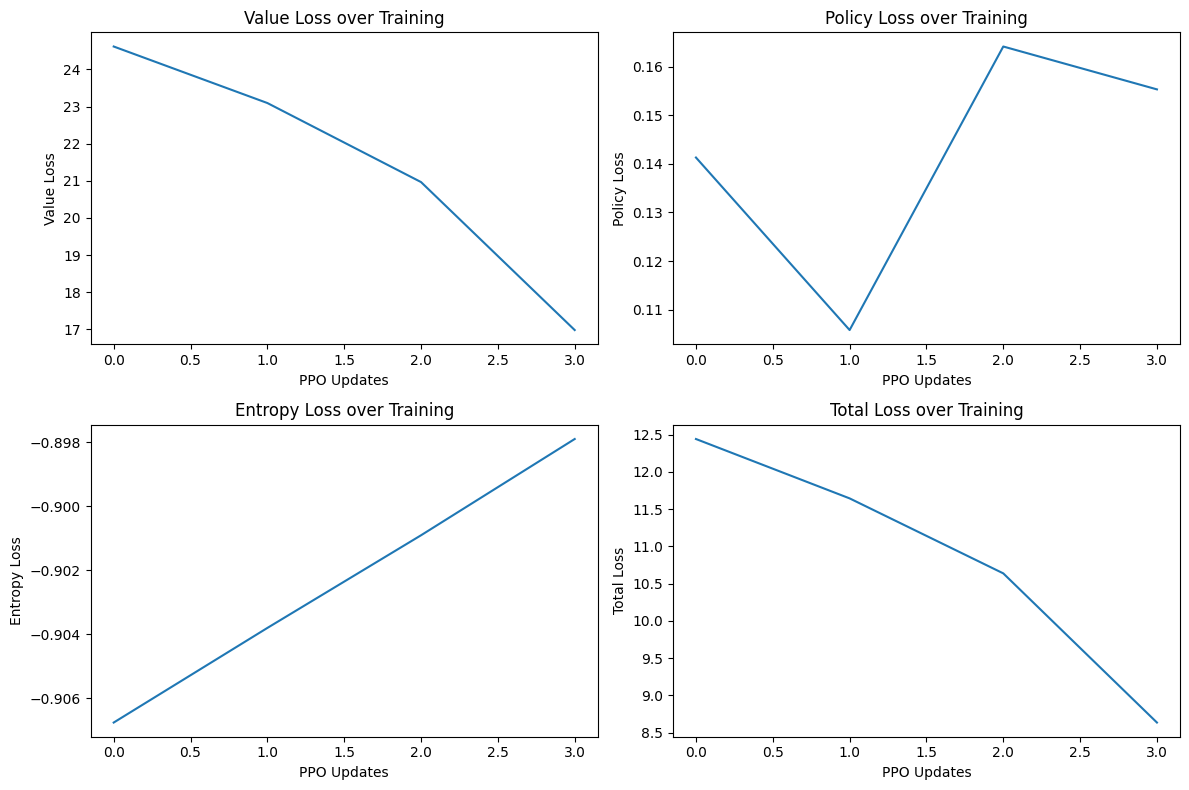

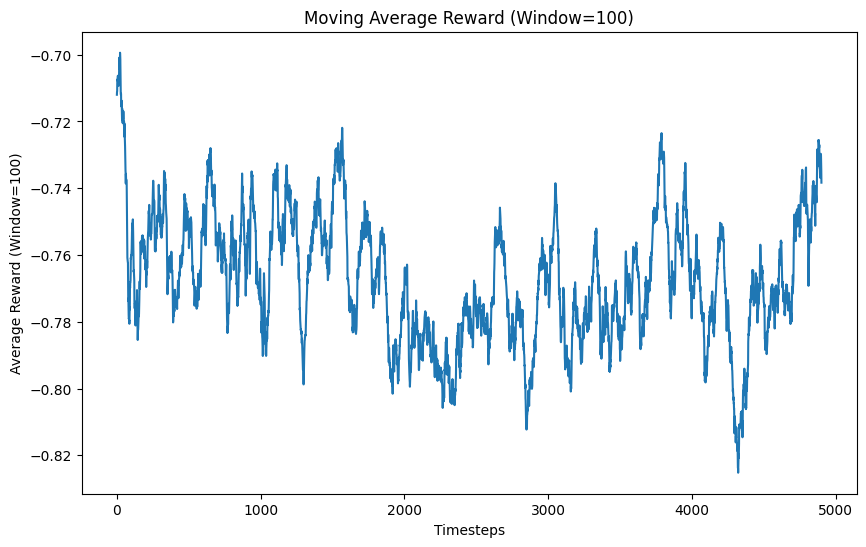

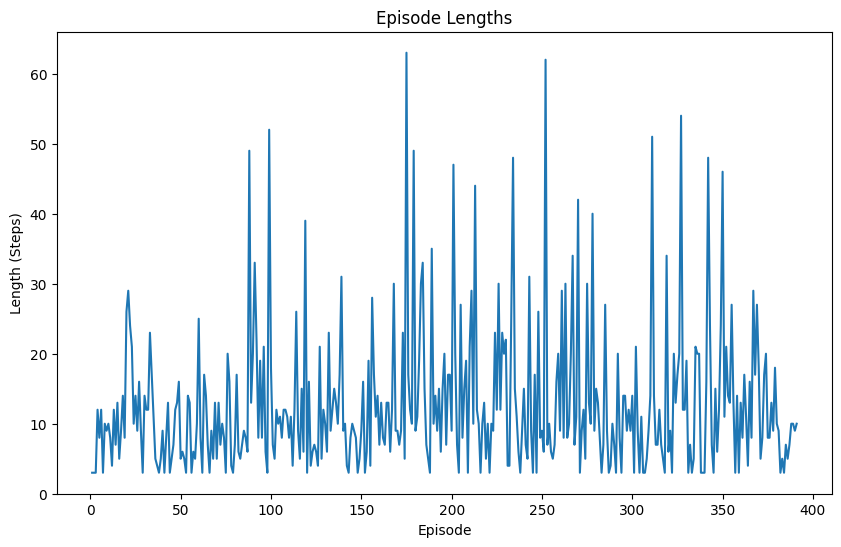

Plots saved at timestep 5000
Ep 392 | Steps:   21 | Avg Ep Len: 12.8 | Total Steps:  5011/40000 | Ep Return: -15.34 | Avg Return:  -9.79 | Reward/Step: -0.730±0.183 | Action STD: 0.570
Ep 393 | Steps:    3 | Avg Ep Len: 12.8 | Total Steps:  5014/40000 | Ep Return:  -2.14 | Avg Return:  -9.75 | Reward/Step: -0.715±0.078 | Action STD: 0.570
Ep 394 | Steps:    6 | Avg Ep Len: 12.8 | Total Steps:  5020/40000 | Ep Return:  -4.29 | Avg Return:  -9.77 | Reward/Step: -0.715±0.072 | Action STD: 0.570
Ep 395 | Steps:    3 | Avg Ep Len: 12.7 | Total Steps:  5023/40000 | Ep Return:  -2.18 | Avg Return:  -9.69 | Reward/Step: -0.727±0.073 | Action STD: 0.570
Ep 396 | Steps:   27 | Avg Ep Len: 12.8 | Total Steps:  5050/40000 | Ep Return: -21.51 | Avg Return:  -9.79 | Reward/Step: -0.797±0.083 | Action STD: 0.570
Ep 397 | Steps:    4 | Avg Ep Len: 12.8 | Total Steps:  5054/40000 | Ep Return:  -2.87 | Avg Return:  -9.75 | Reward/Step: -0.718±0.062 | Action STD: 0.570
Ep 398 | Steps:    4 | Avg Ep Len: 

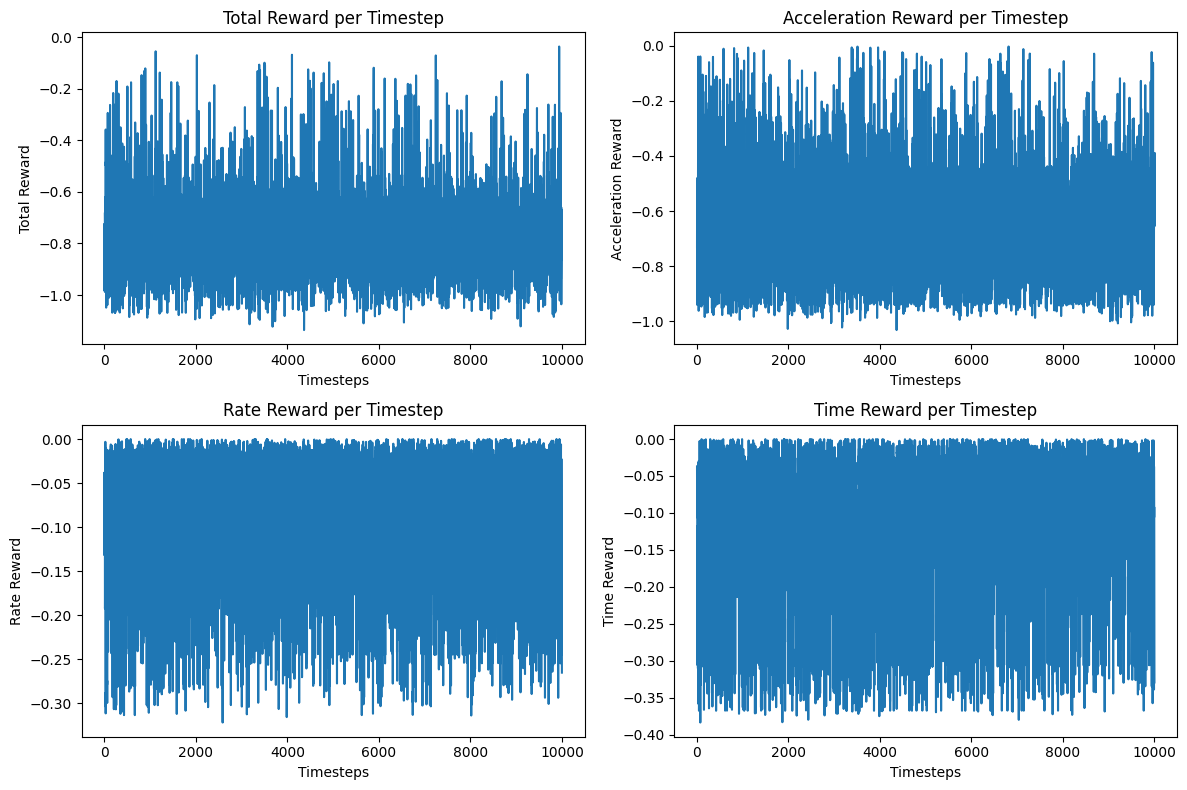

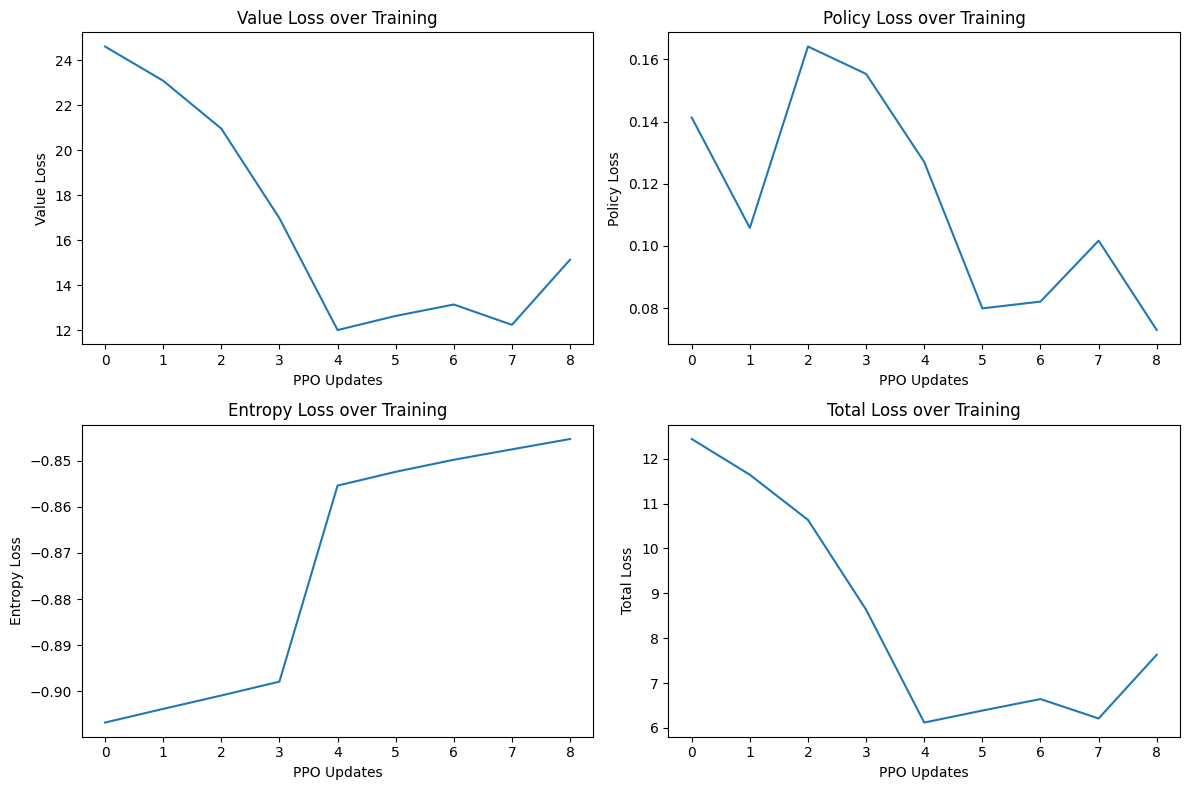

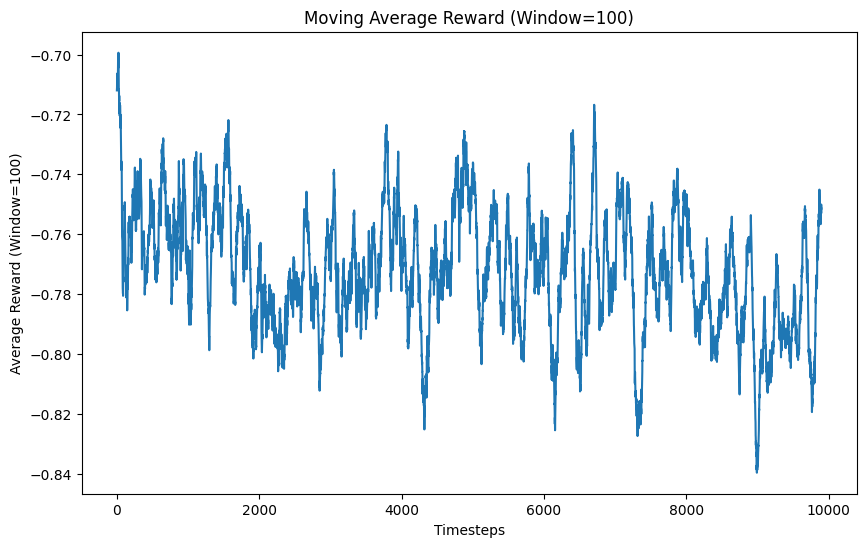

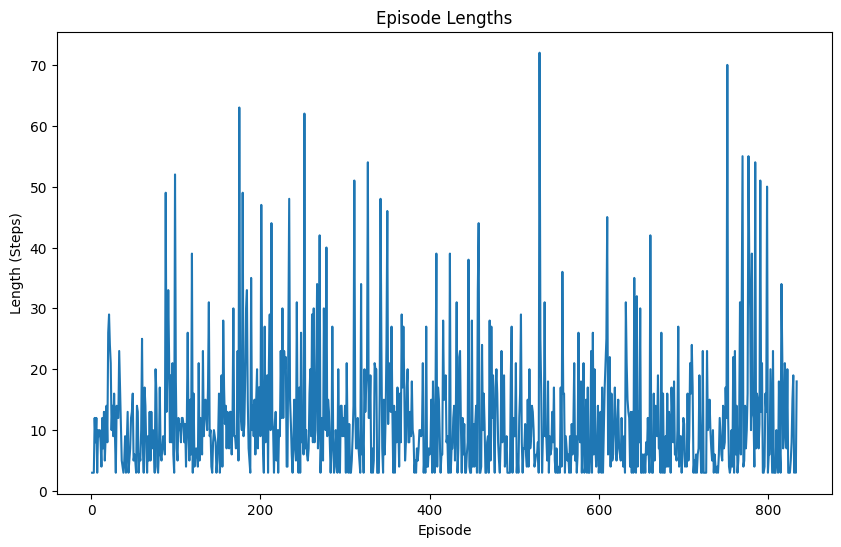

Plots saved at timestep 10000
Ep 835 | Steps:   12 | Avg Ep Len: 13.4 | Total Steps: 10003/40000 | Ep Return:  -8.91 | Avg Return: -10.54 | Reward/Step: -0.742±0.095 | Action STD: 0.541
Ep 836 | Steps:    3 | Avg Ep Len: 13.4 | Total Steps: 10006/40000 | Ep Return:  -1.92 | Avg Return: -10.53 | Reward/Step: -0.639±0.057 | Action STD: 0.541
Ep 837 | Steps:   11 | Avg Ep Len: 13.4 | Total Steps: 10017/40000 | Ep Return:  -9.31 | Avg Return: -10.58 | Reward/Step: -0.847±0.062 | Action STD: 0.541
Ep 838 | Steps:   11 | Avg Ep Len: 13.5 | Total Steps: 10028/40000 | Ep Return:  -9.45 | Avg Return: -10.64 | Reward/Step: -0.859±0.101 | Action STD: 0.541
Ep 839 | Steps:   13 | Avg Ep Len: 13.6 | Total Steps: 10041/40000 | Ep Return: -11.16 | Avg Return: -10.72 | Reward/Step: -0.858±0.095 | Action STD: 0.541
Ep 840 | Steps:    6 | Avg Ep Len: 13.6 | Total Steps: 10047/40000 | Ep Return:  -4.96 | Avg Return: -10.75 | Reward/Step: -0.826±0.156 | Action STD: 0.541
Ep 841 | Steps:   20 | Avg Ep Len:

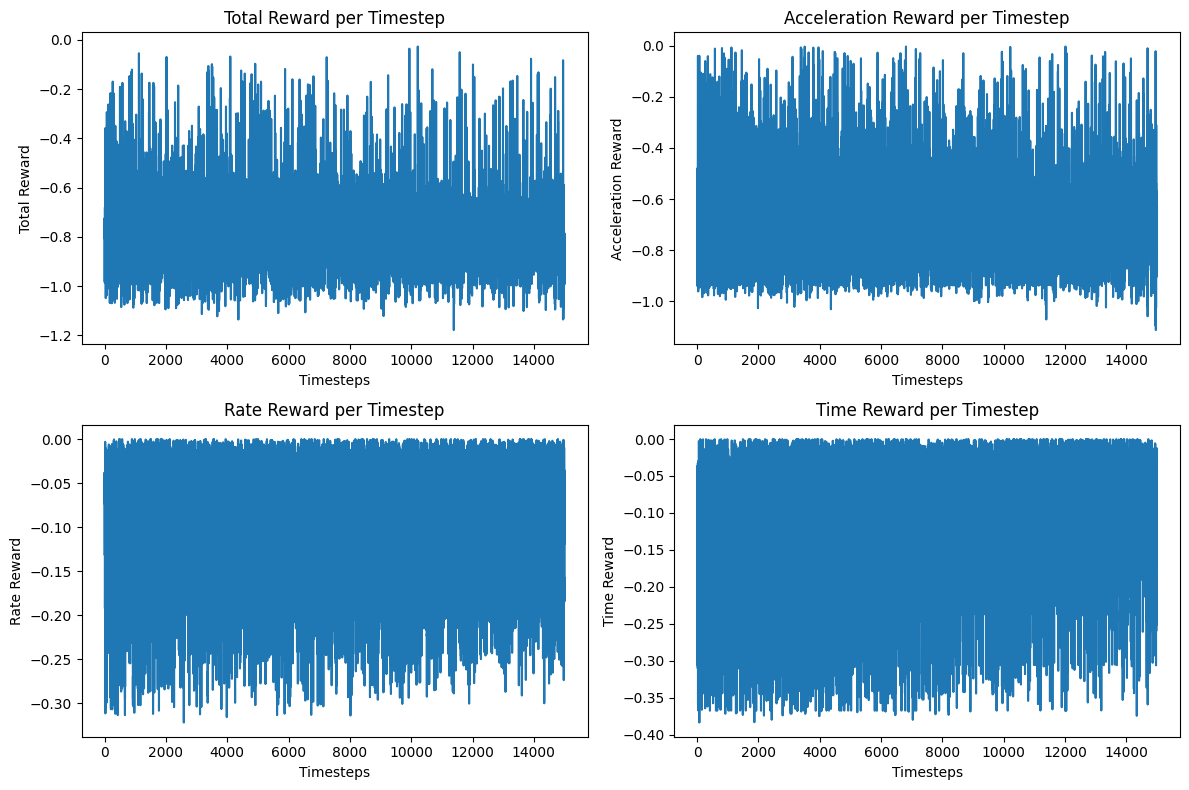

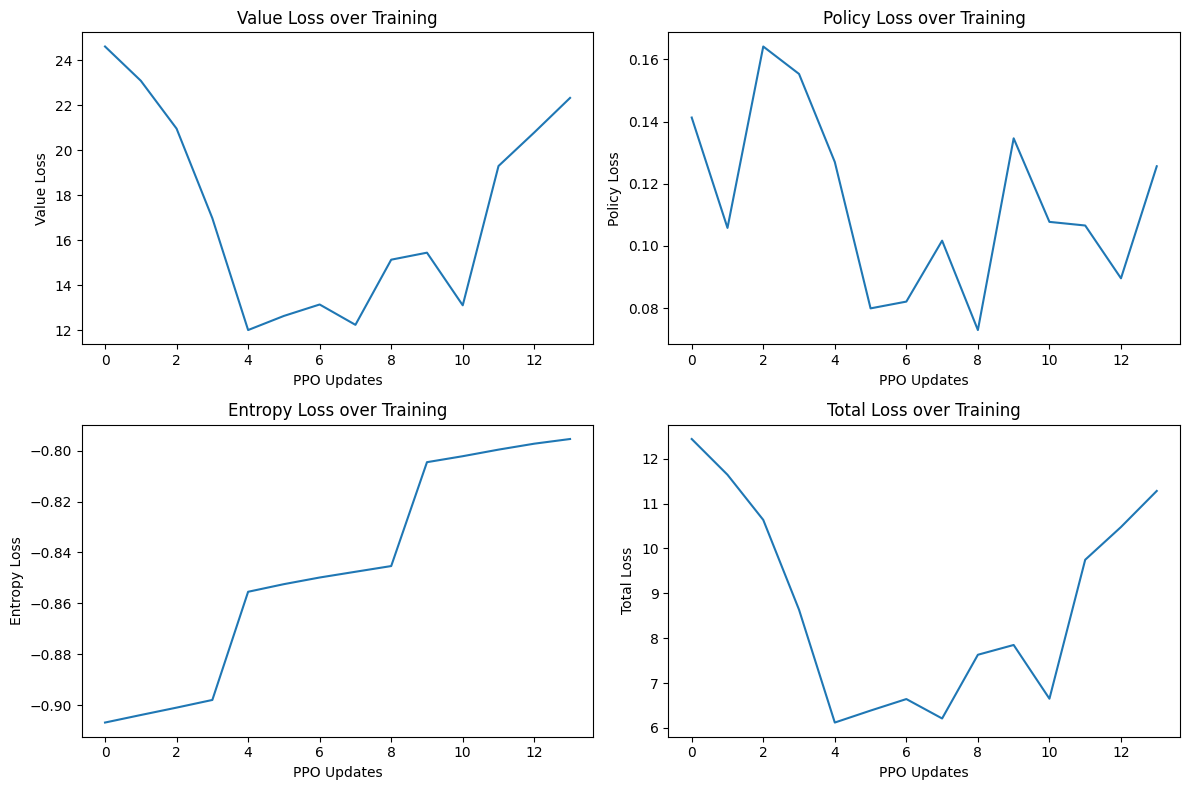

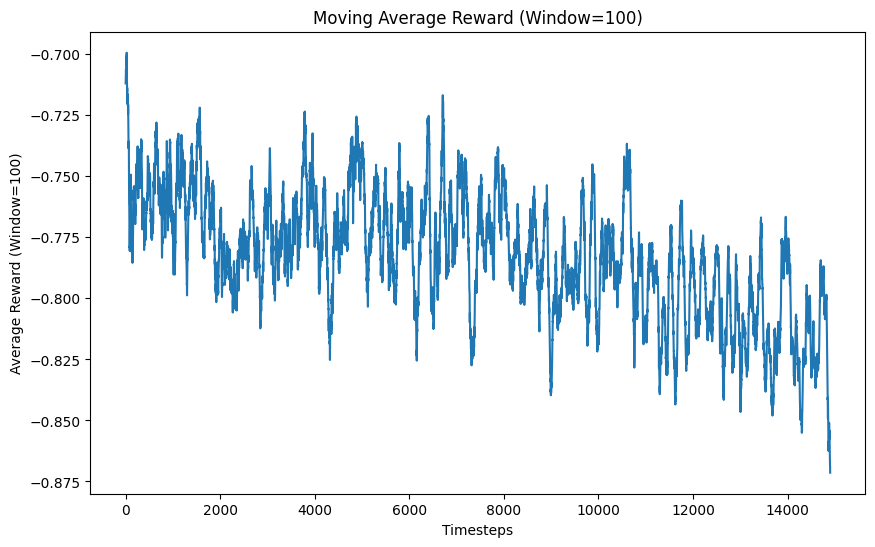

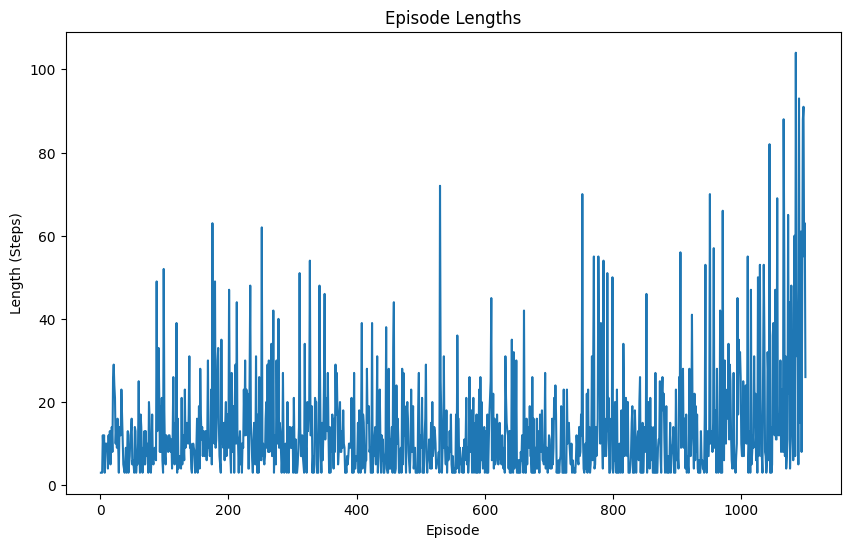

Plots saved at timestep 15000
Ep 1101 | Steps:  200 | Avg Ep Len: 28.1 | Total Steps: 15057/40000 | Ep Return: -171.45 | Avg Return: -22.85 | Reward/Step: -0.857±0.128 | Action STD: 0.514
Ep 1102 | Steps:  102 | Avg Ep Len: 29.1 | Total Steps: 15159/40000 | Ep Return: -83.07 | Avg Return: -23.62 | Reward/Step: -0.814±0.099 | Action STD: 0.514
Ep 1103 | Steps:   31 | Avg Ep Len: 29.1 | Total Steps: 15190/40000 | Ep Return: -23.10 | Avg Return: -23.67 | Reward/Step: -0.745±0.116 | Action STD: 0.514
Ep 1104 | Steps:   57 | Avg Ep Len: 29.6 | Total Steps: 15247/40000 | Ep Return: -48.28 | Avg Return: -24.09 | Reward/Step: -0.847±0.082 | Action STD: 0.514
Ep 1105 | Steps:   15 | Avg Ep Len: 29.6 | Total Steps: 15262/40000 | Ep Return: -10.50 | Avg Return: -24.03 | Reward/Step: -0.700±0.148 | Action STD: 0.514
Ep 1106 | Steps:    8 | Avg Ep Len: 29.4 | Total Steps: 15270/40000 | Ep Return:  -6.65 | Avg Return: -23.95 | Reward/Step: -0.832±0.044 | Action STD: 0.514
Ep 1107 | Steps:   52 | Avg

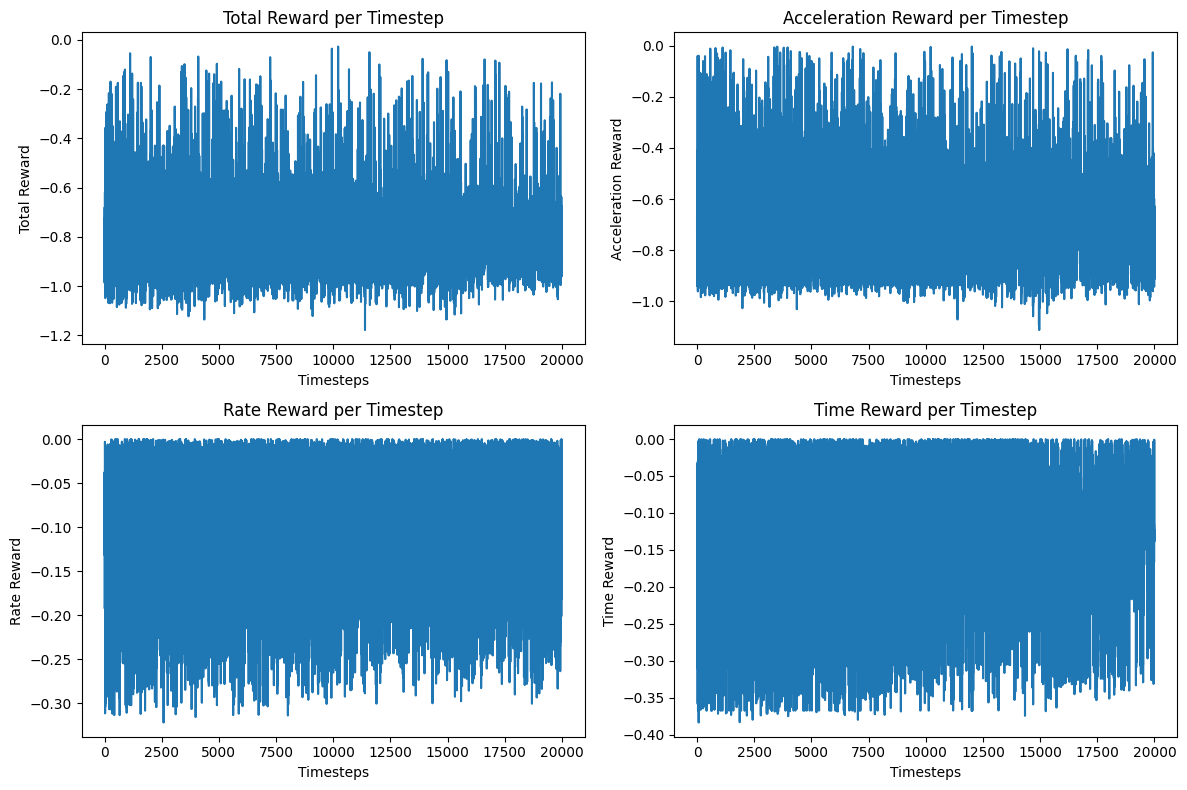

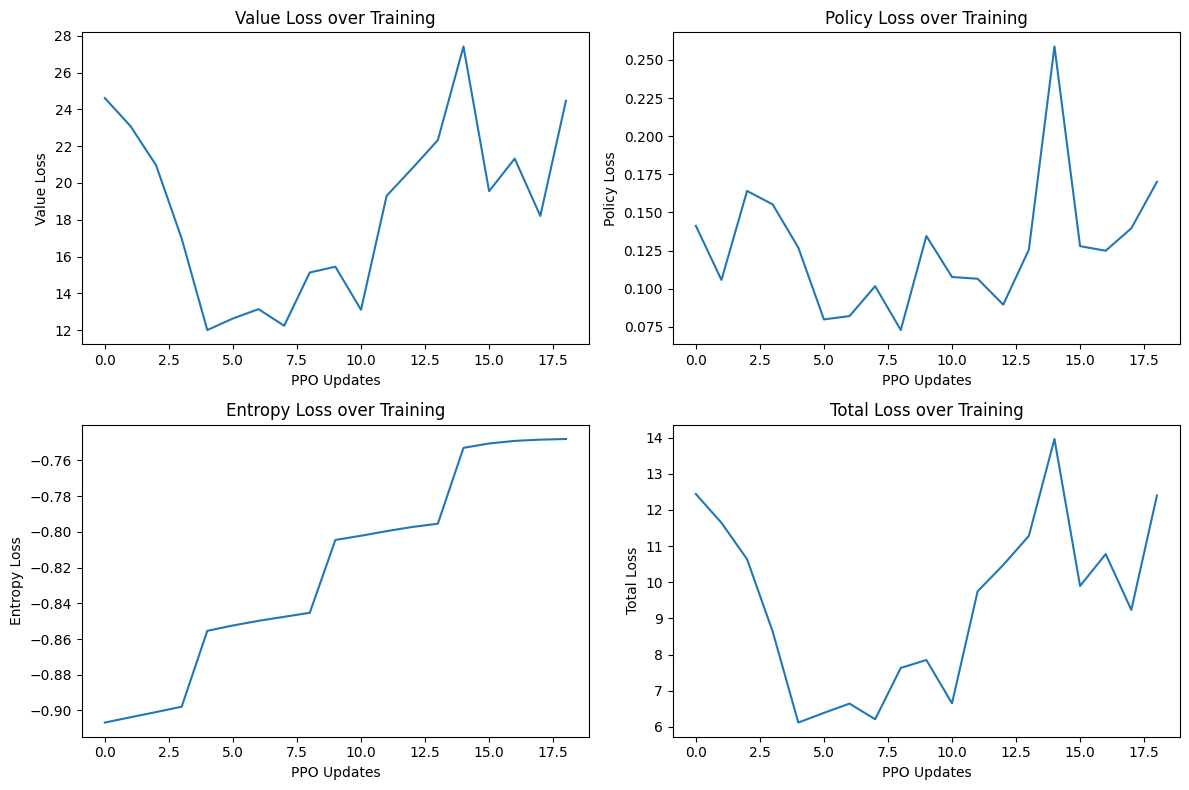

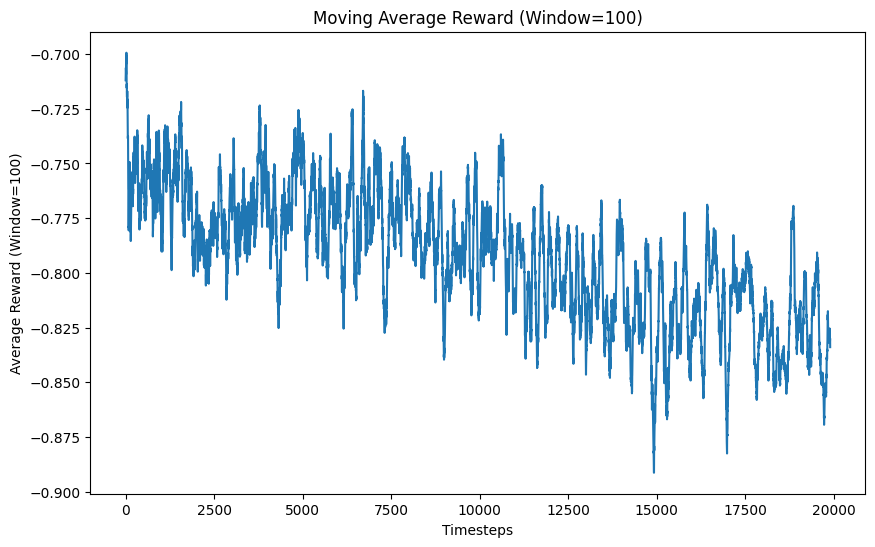

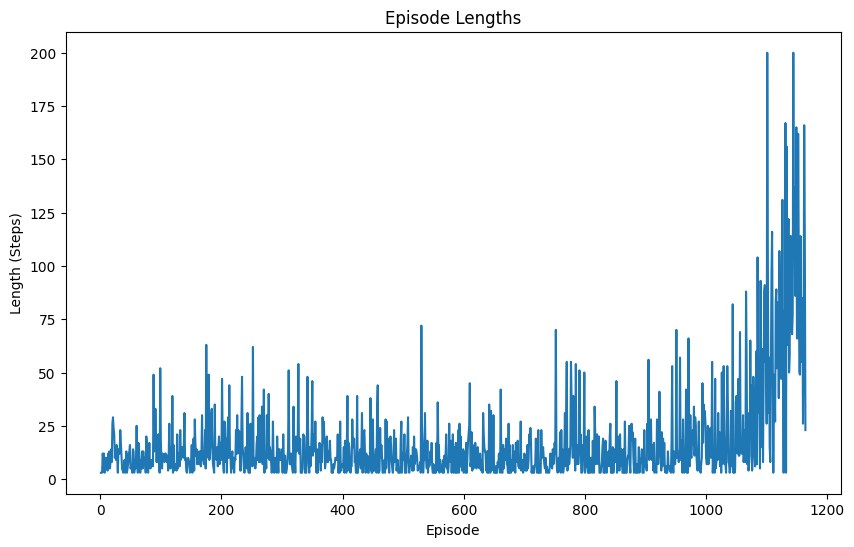

Plots saved at timestep 20000
Ep 1165 | Steps:   39 | Avg Ep Len: 65.3 | Total Steps: 20011/40000 | Ep Return: -32.12 | Avg Return: -53.56 | Reward/Step: -0.824±0.082 | Action STD: 0.489
Ep 1166 | Steps:  117 | Avg Ep Len: 65.6 | Total Steps: 20128/40000 | Ep Return: -96.96 | Avg Return: -53.82 | Reward/Step: -0.829±0.086 | Action STD: 0.489
Ep 1167 | Steps:  108 | Avg Ep Len: 66.1 | Total Steps: 20236/40000 | Ep Return: -85.13 | Avg Return: -54.21 | Reward/Step: -0.788±0.124 | Action STD: 0.489
Ep 1168 | Steps:   78 | Avg Ep Len: 66.8 | Total Steps: 20314/40000 | Ep Return: -63.22 | Avg Return: -54.79 | Reward/Step: -0.811±0.119 | Action STD: 0.489
Ep 1169 | Steps:  113 | Avg Ep Len: 67.6 | Total Steps: 20427/40000 | Ep Return: -92.58 | Avg Return: -55.47 | Reward/Step: -0.819±0.105 | Action STD: 0.489
PPO Update at step 20480 | Value Loss: 22.7872 | Policy Loss: 0.1351 | Entropy: -0.7029
Ep 1170 | Steps:   67 | Avg Ep Len: 68.2 | Total Steps: 20494/40000 | Ep Return: -53.57 | Avg Ret

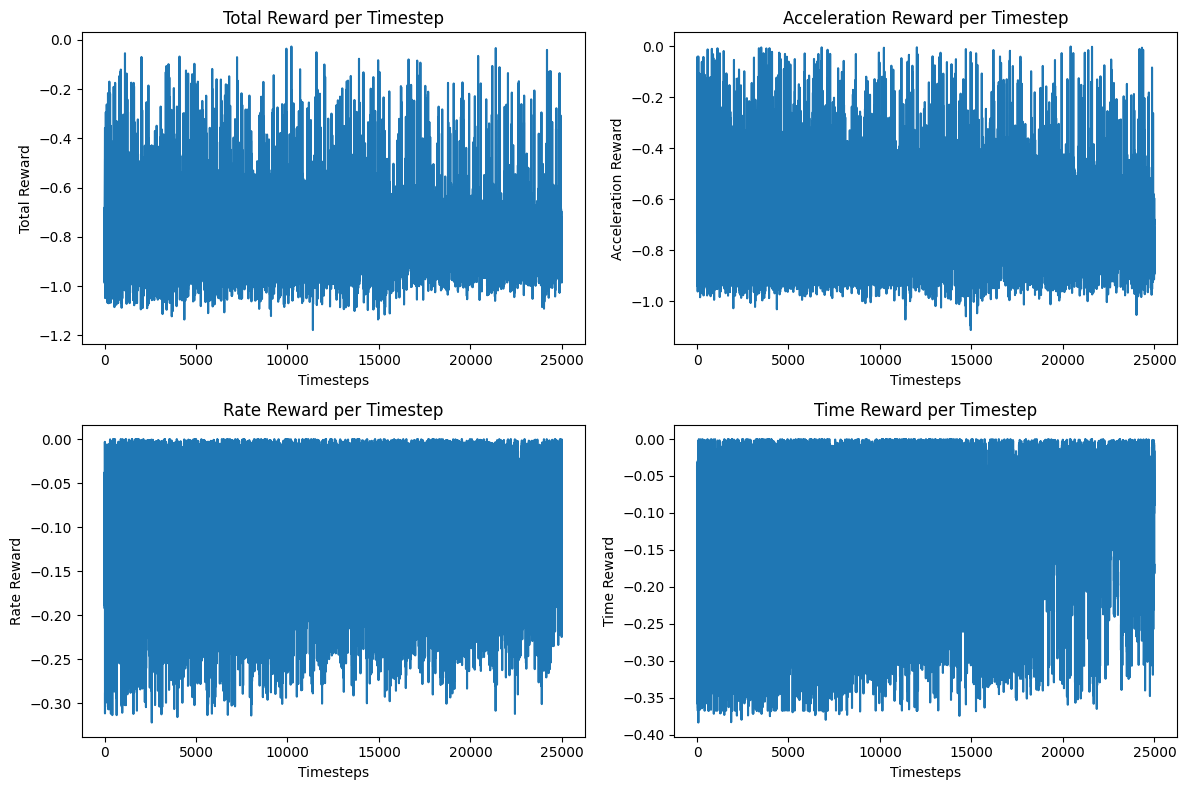

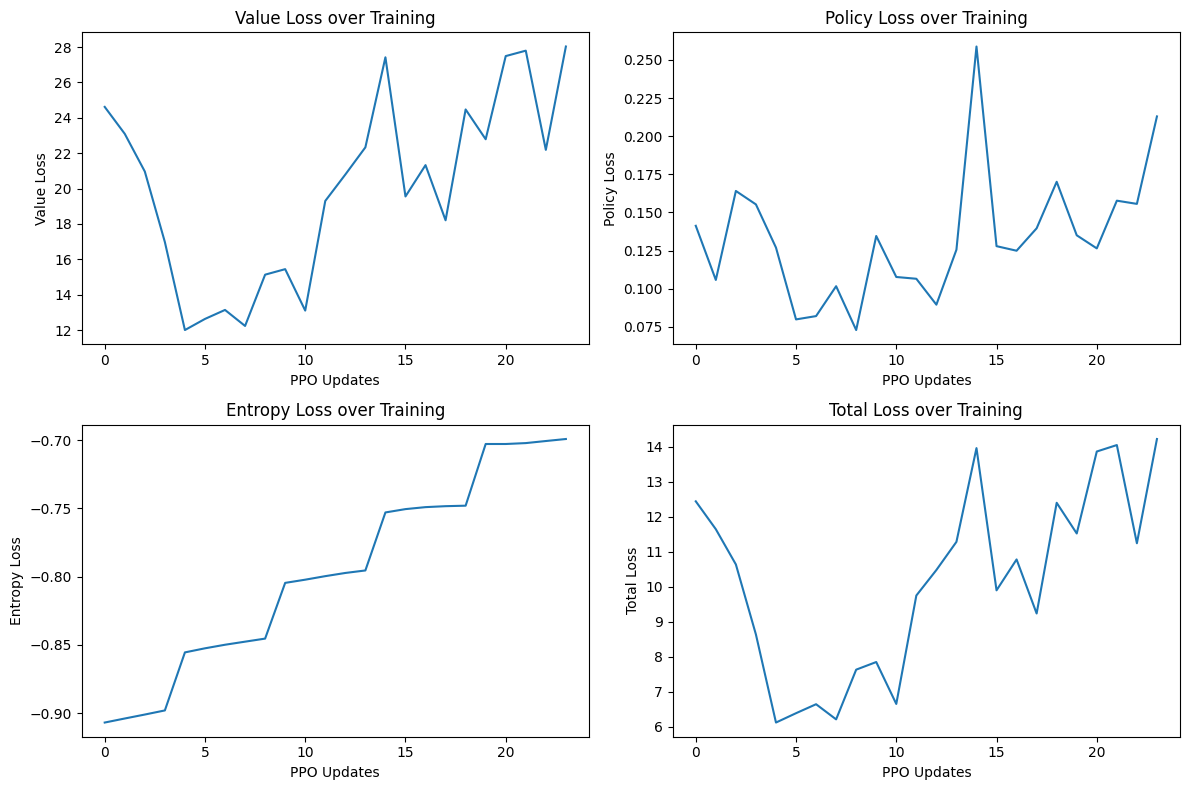

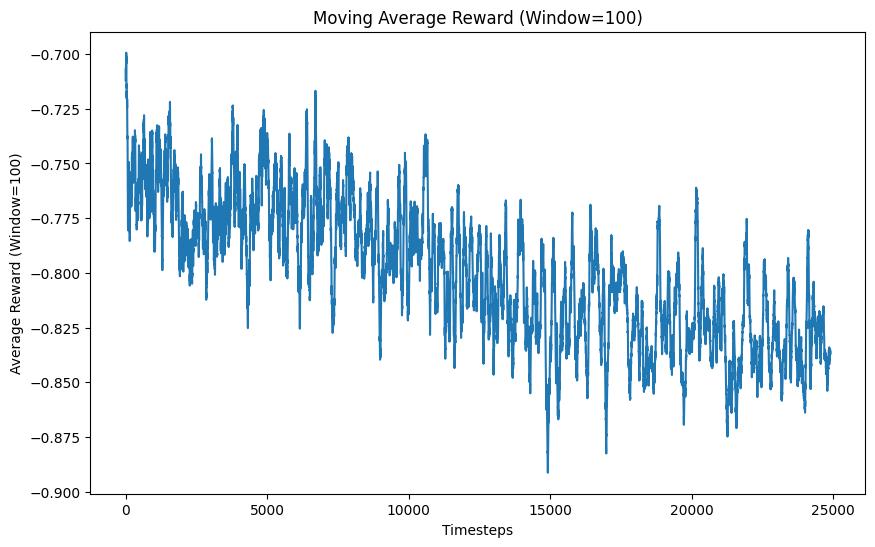

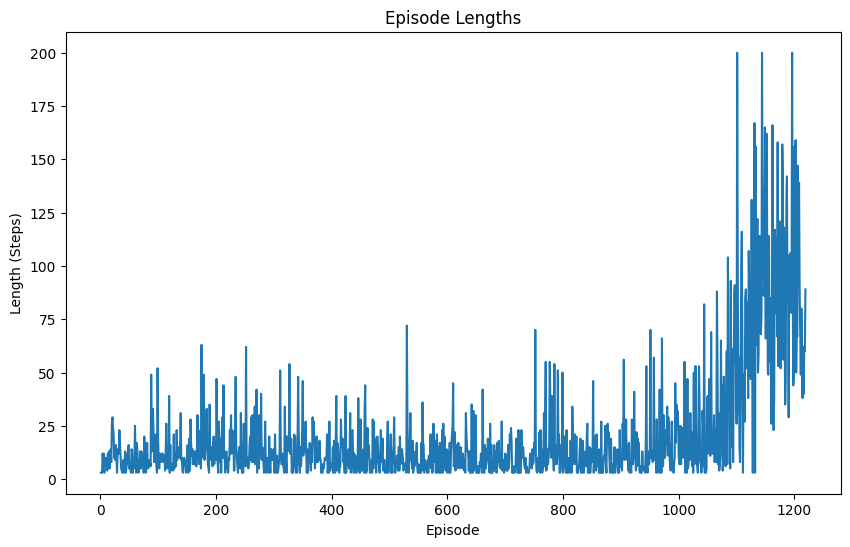

Plots saved at timestep 25000
Ep 1220 | Steps:  140 | Avg Ep Len: 89.2 | Total Steps: 25042/40000 | Ep Return: -116.91 | Avg Return: -73.65 | Reward/Step: -0.835±0.089 | Action STD: 0.464
Ep 1221 | Steps:   64 | Avg Ep Len: 88.8 | Total Steps: 25106/40000 | Ep Return: -53.89 | Avg Return: -73.32 | Reward/Step: -0.842±0.075 | Action STD: 0.464
Ep 1222 | Steps:   25 | Avg Ep Len: 88.2 | Total Steps: 25131/40000 | Ep Return: -20.24 | Avg Return: -72.83 | Reward/Step: -0.810±0.104 | Action STD: 0.464
Ep 1223 | Steps:   29 | Avg Ep Len: 87.8 | Total Steps: 25160/40000 | Ep Return: -23.19 | Avg Return: -72.50 | Reward/Step: -0.800±0.079 | Action STD: 0.464
Ep 1224 | Steps:   57 | Avg Ep Len: 87.9 | Total Steps: 25217/40000 | Ep Return: -44.62 | Avg Return: -72.54 | Reward/Step: -0.783±0.083 | Action STD: 0.464
Ep 1225 | Steps:   49 | Avg Ep Len: 87.8 | Total Steps: 25266/40000 | Ep Return: -40.70 | Avg Return: -72.47 | Reward/Step: -0.831±0.085 | Action STD: 0.464
Ep 1226 | Steps:   27 | Avg

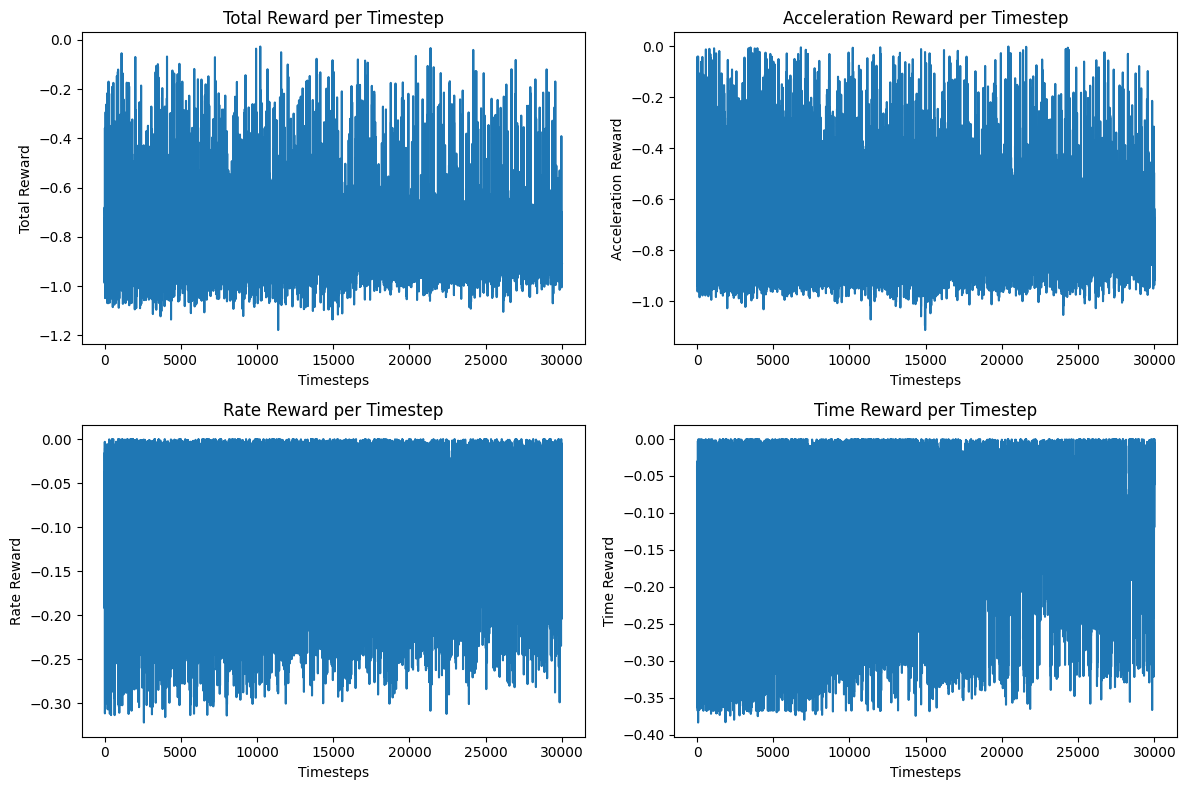

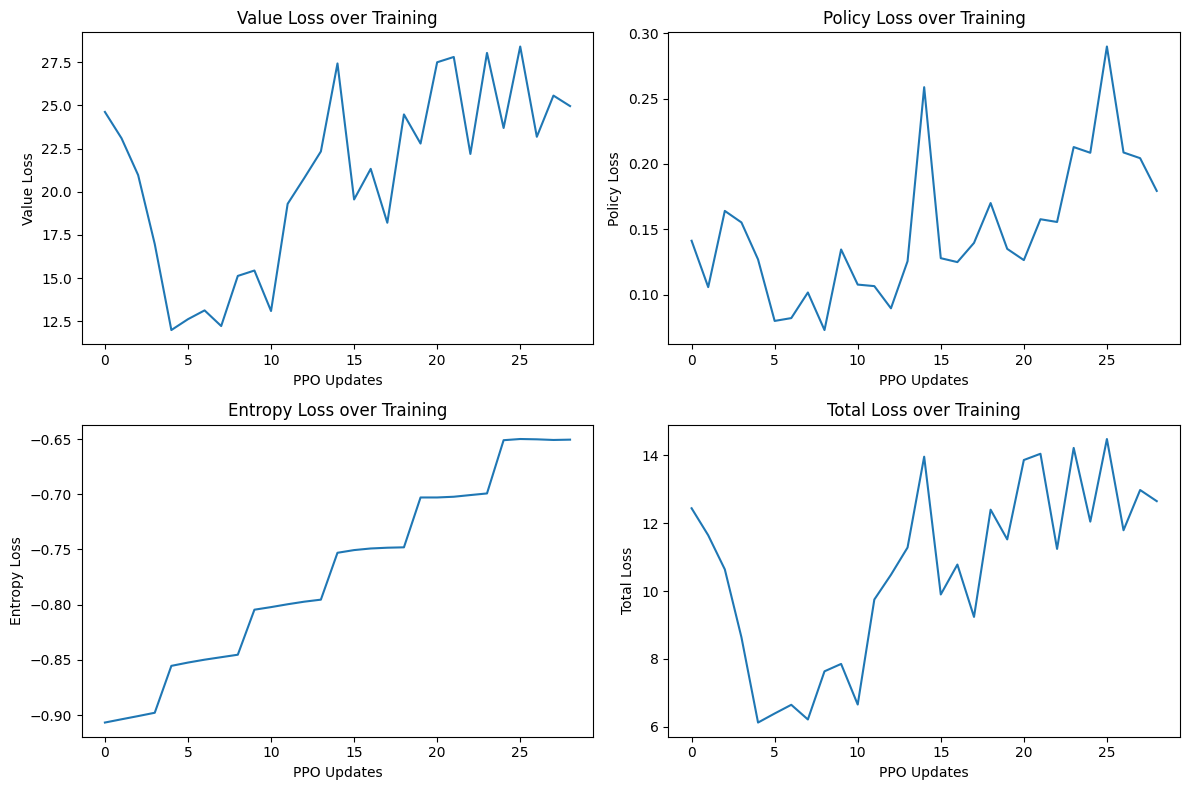

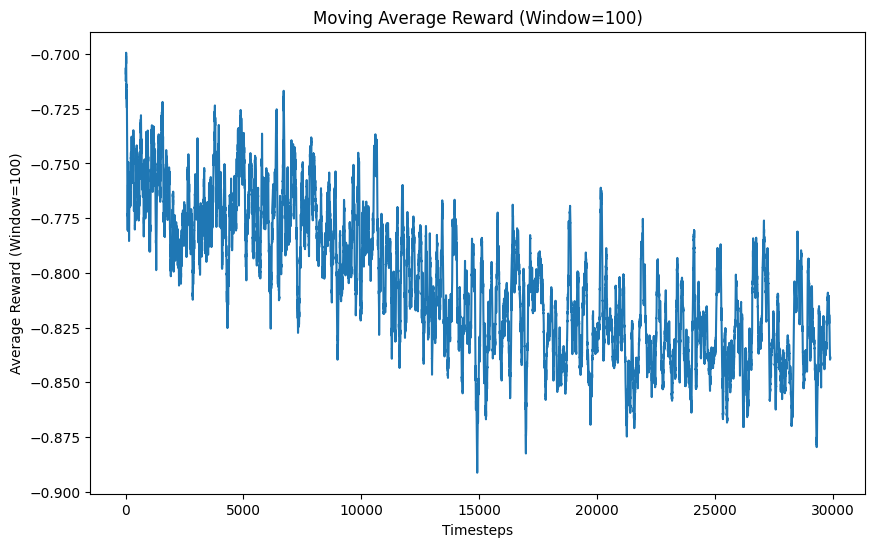

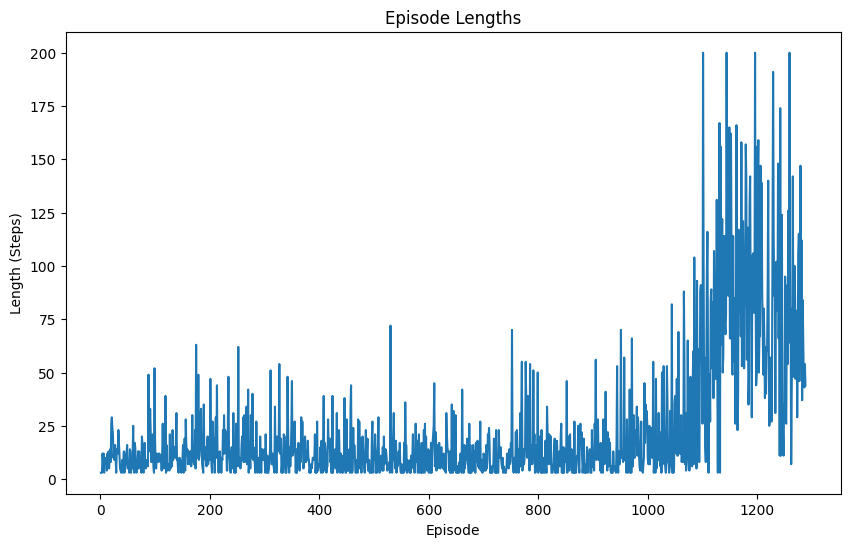

Plots saved at timestep 30000
Ep 1289 | Steps:   62 | Avg Ep Len: 77.6 | Total Steps: 30054/40000 | Ep Return: -50.91 | Avg Return: -64.34 | Reward/Step: -0.821±0.107 | Action STD: 0.441
Ep 1290 | Steps:   64 | Avg Ep Len: 77.9 | Total Steps: 30118/40000 | Ep Return: -53.37 | Avg Return: -64.64 | Reward/Step: -0.834±0.100 | Action STD: 0.441
Ep 1291 | Steps:  121 | Avg Ep Len: 78.1 | Total Steps: 30239/40000 | Ep Return: -101.60 | Avg Return: -64.77 | Reward/Step: -0.840±0.056 | Action STD: 0.441
Ep 1292 | Steps:  101 | Avg Ep Len: 78.3 | Total Steps: 30340/40000 | Ep Return: -84.15 | Avg Return: -64.94 | Reward/Step: -0.833±0.069 | Action STD: 0.441
Ep 1293 | Steps:   77 | Avg Ep Len: 78.0 | Total Steps: 30417/40000 | Ep Return: -64.82 | Avg Return: -64.71 | Reward/Step: -0.842±0.063 | Action STD: 0.441
Ep 1294 | Steps:  131 | Avg Ep Len: 78.5 | Total Steps: 30548/40000 | Ep Return: -108.28 | Avg Return: -65.16 | Reward/Step: -0.827±0.099 | Action STD: 0.441
Ep 1295 | Steps:   54 | Av

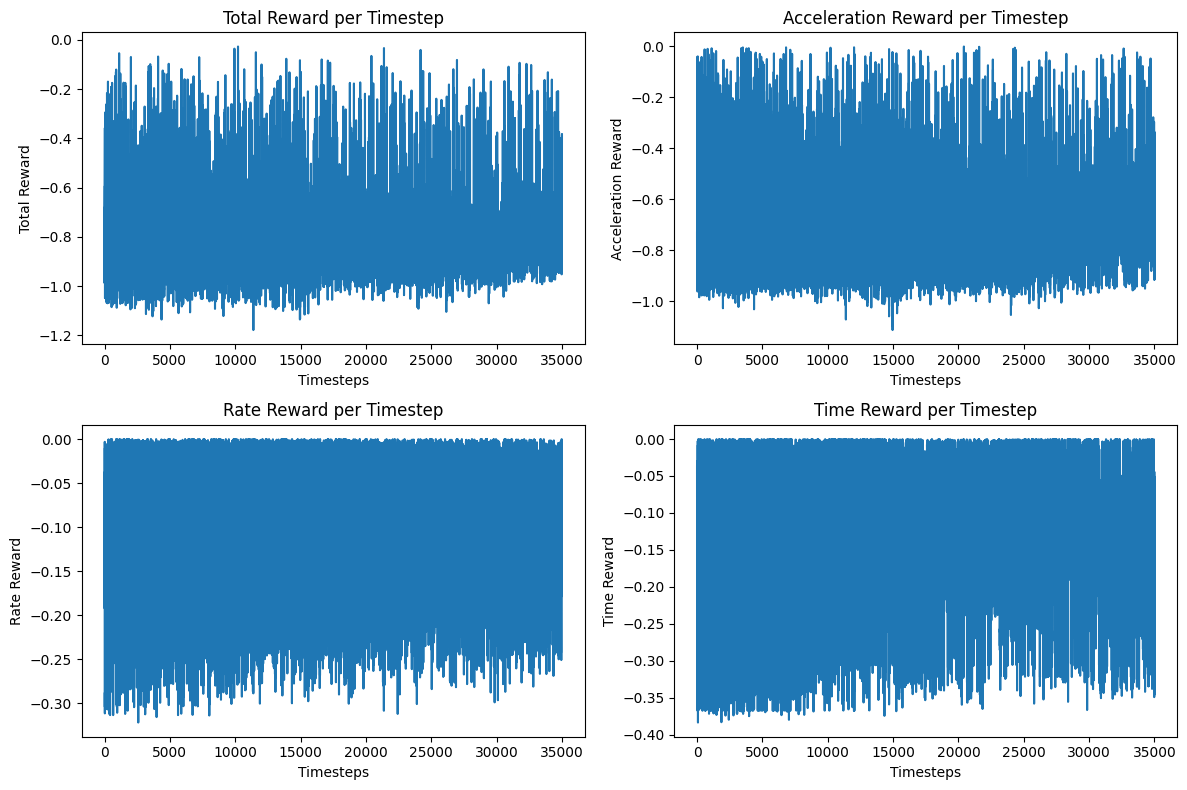

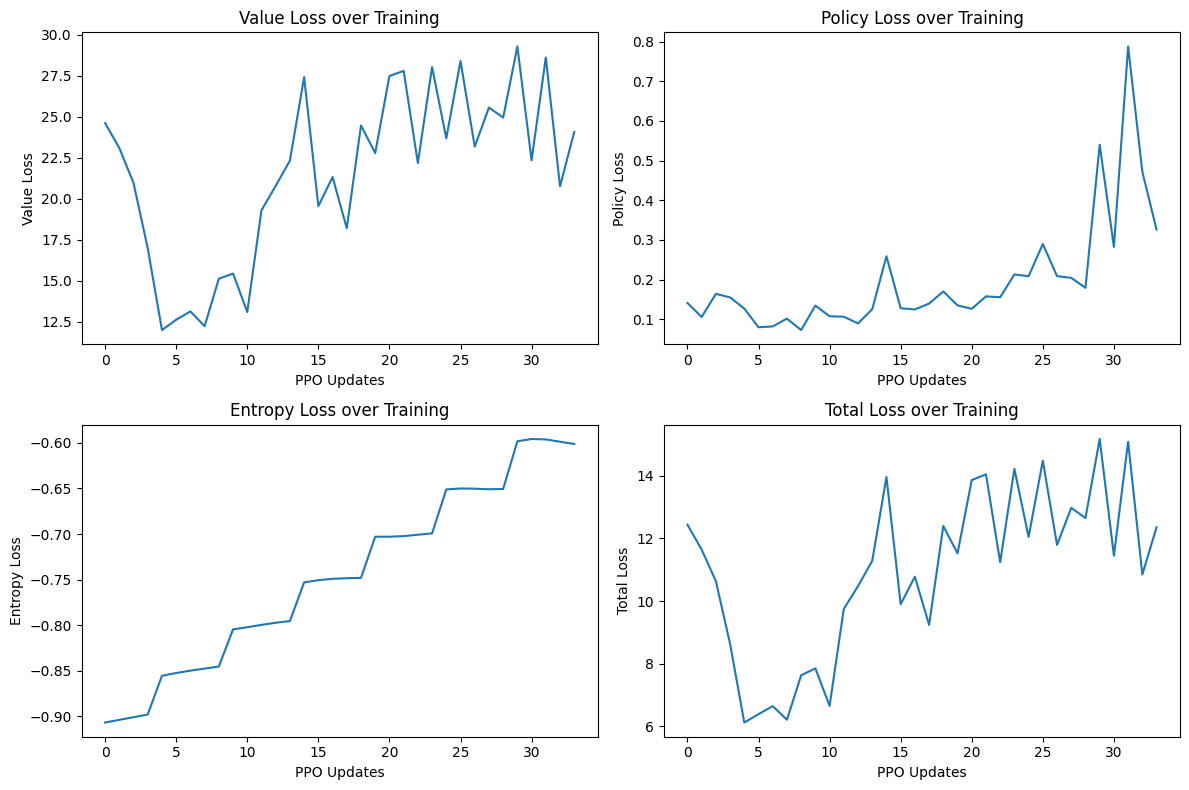

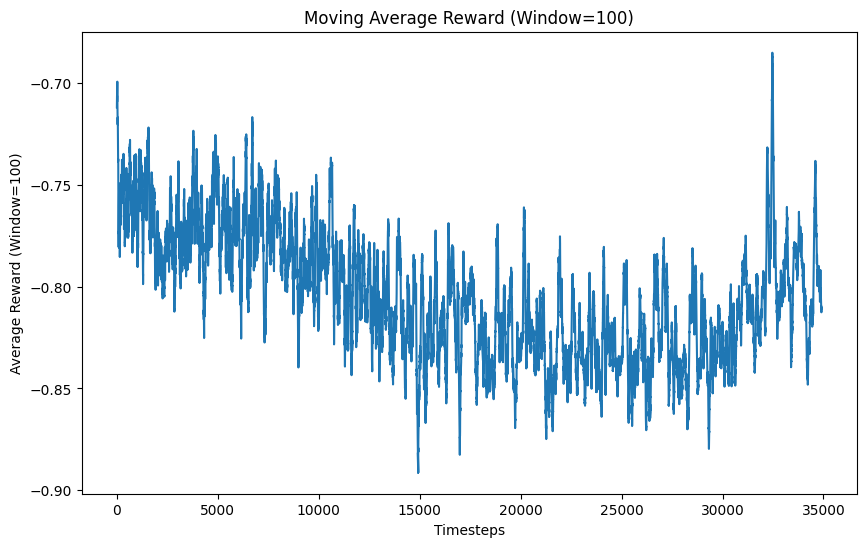

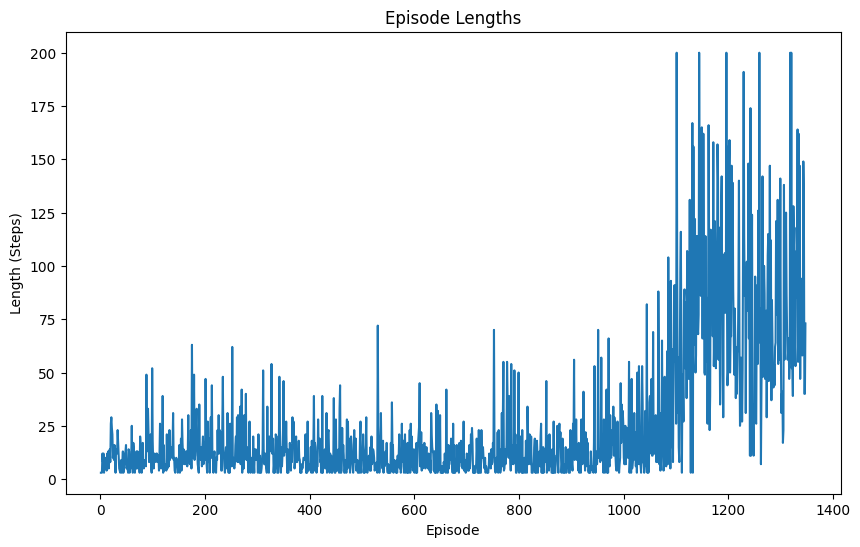

Plots saved at timestep 35000
Ep 1348 | Steps:  155 | Avg Ep Len: 79.7 | Total Steps: 35084/40000 | Ep Return: -118.30 | Avg Return: -64.64 | Reward/Step: -0.763±0.123 | Action STD: 0.419
Ep 1349 | Steps:   50 | Avg Ep Len: 79.8 | Total Steps: 35134/40000 | Ep Return: -37.01 | Avg Return: -64.73 | Reward/Step: -0.740±0.141 | Action STD: 0.419
Ep 1350 | Steps:   58 | Avg Ep Len: 80.0 | Total Steps: 35192/40000 | Ep Return: -46.73 | Avg Return: -64.93 | Reward/Step: -0.806±0.111 | Action STD: 0.419
Ep 1351 | Steps:   44 | Avg Ep Len: 79.5 | Total Steps: 35236/40000 | Ep Return: -35.97 | Avg Return: -64.50 | Reward/Step: -0.818±0.067 | Action STD: 0.419
Ep 1352 | Steps:  200 | Avg Ep Len: 81.3 | Total Steps: 35436/40000 | Ep Return: -144.94 | Avg Return: -65.75 | Reward/Step: -0.725±0.125 | Action STD: 0.419
Ep 1353 | Steps:  121 | Avg Ep Len: 82.2 | Total Steps: 35557/40000 | Ep Return: -93.67 | Avg Return: -66.49 | Reward/Step: -0.774±0.133 | Action STD: 0.419
Ep 1354 | Steps:   78 | Av

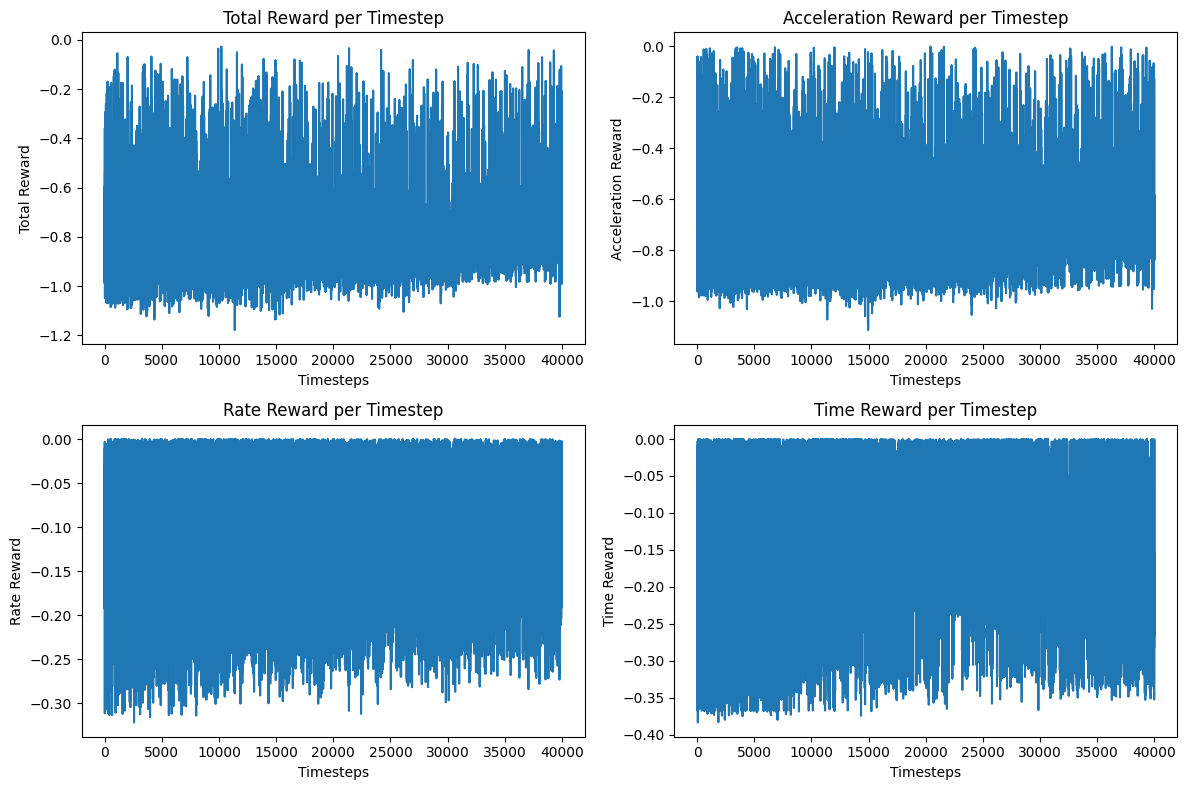

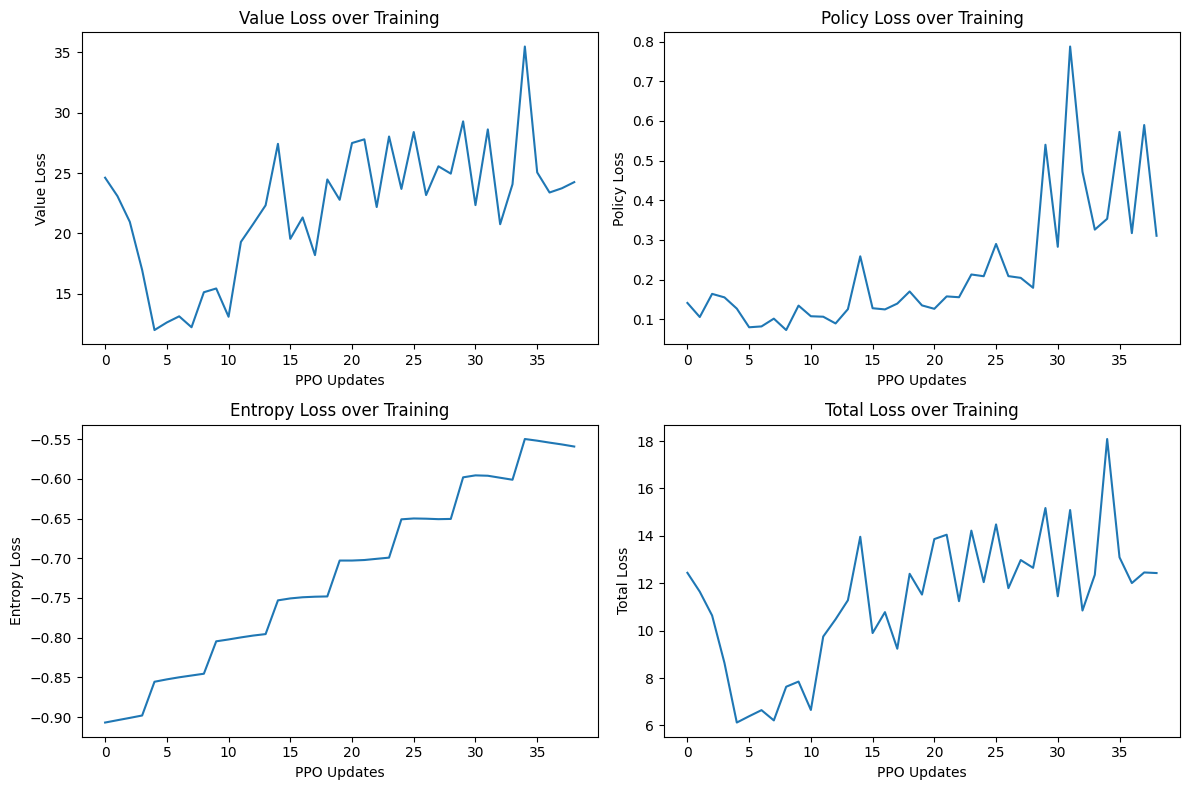

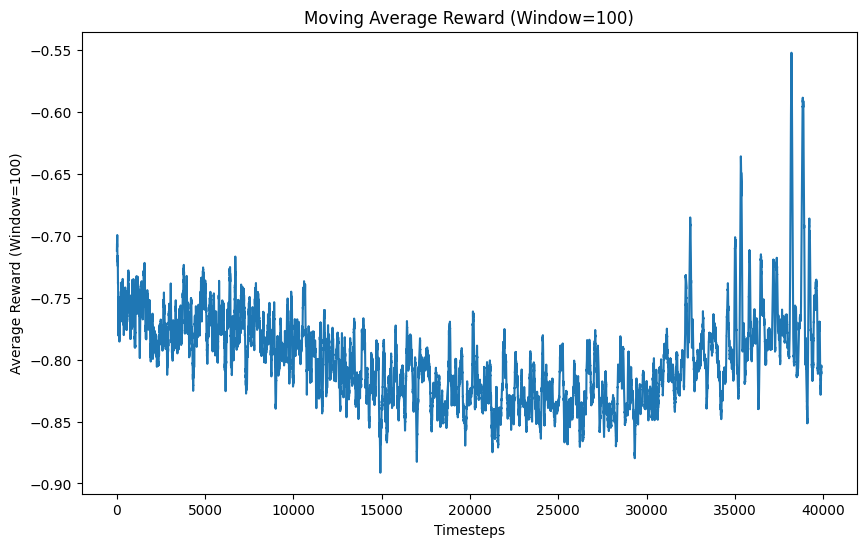

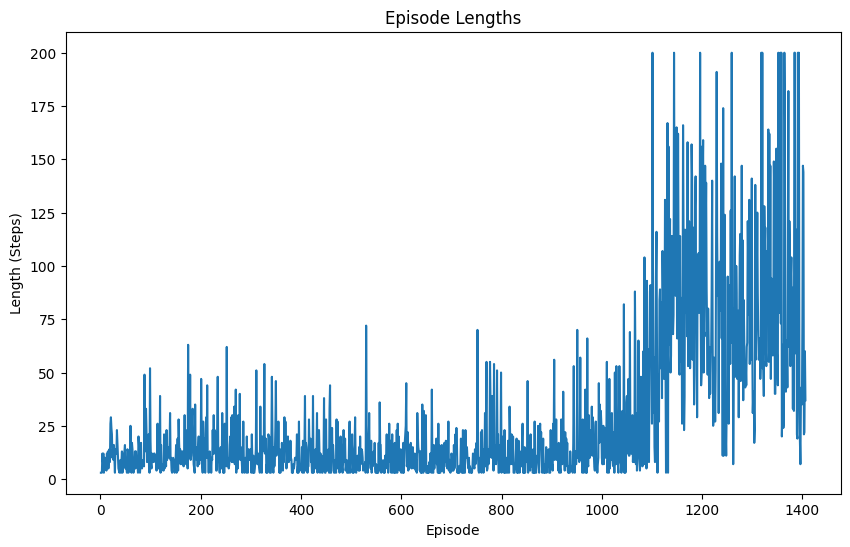

Plots saved at timestep 40000
Ep 1407 | Steps:   26 | Avg Ep Len: 86.3 | Total Steps: 40000/40000 | Ep Return: -20.77 | Avg Return: -67.14 | Reward/Step: -0.799±0.141 | Action STD: 0.398

Training complete! Creating final plots...


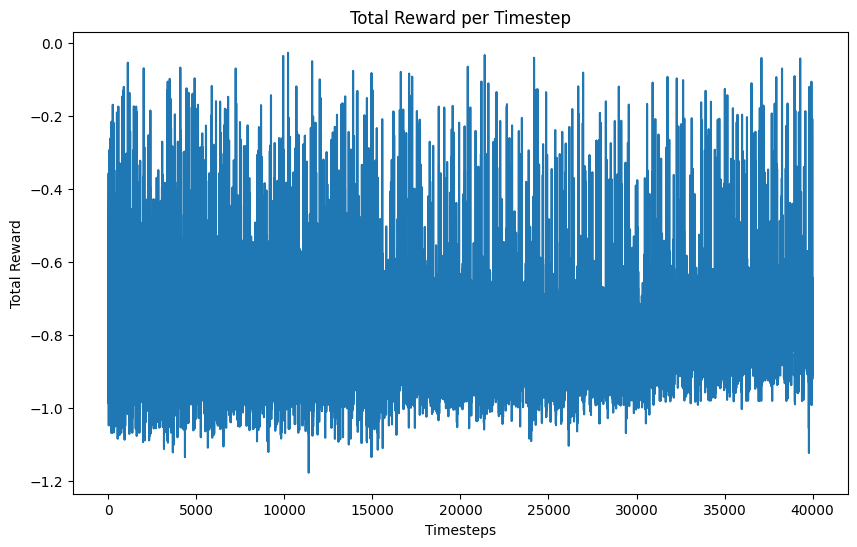

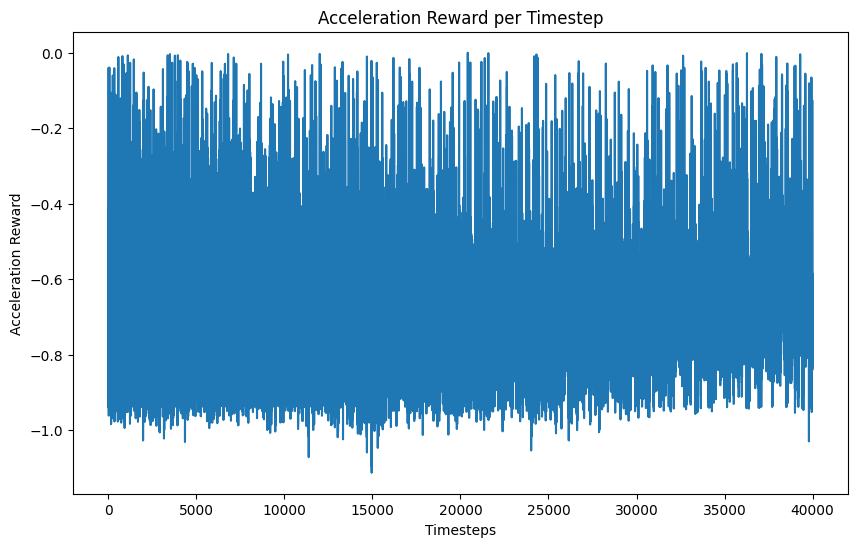

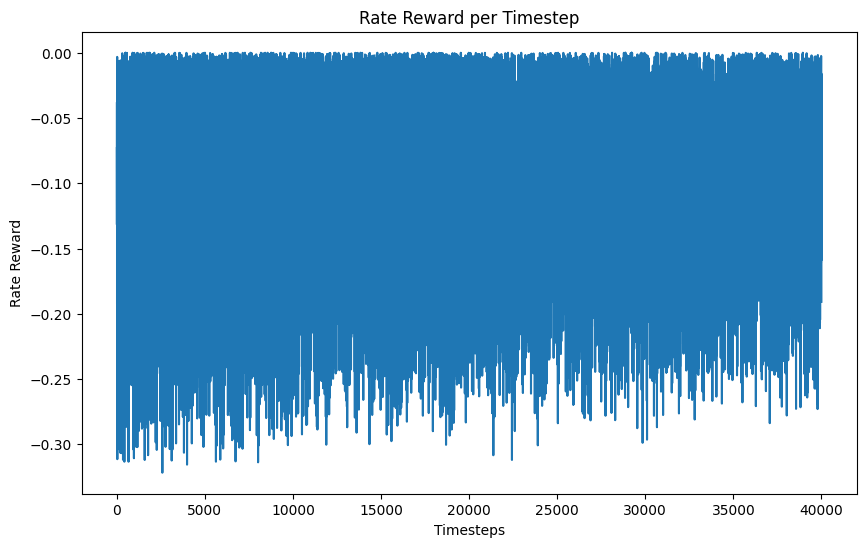

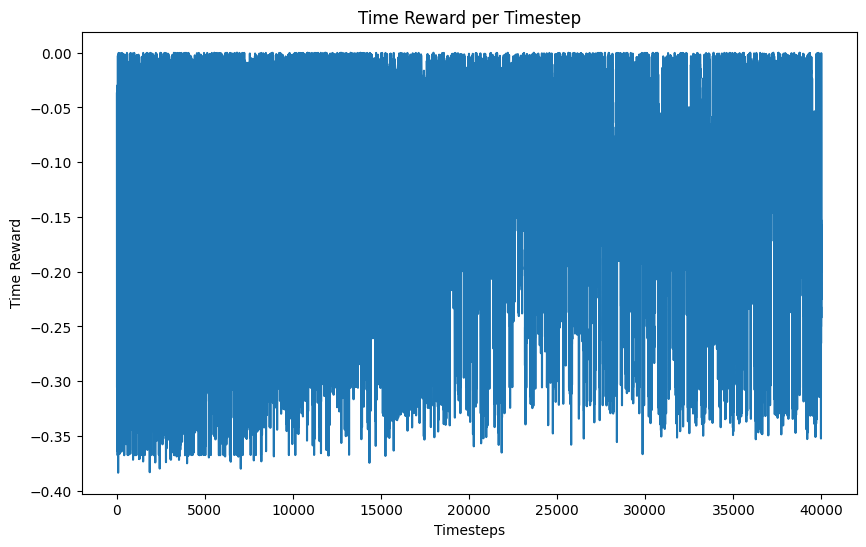

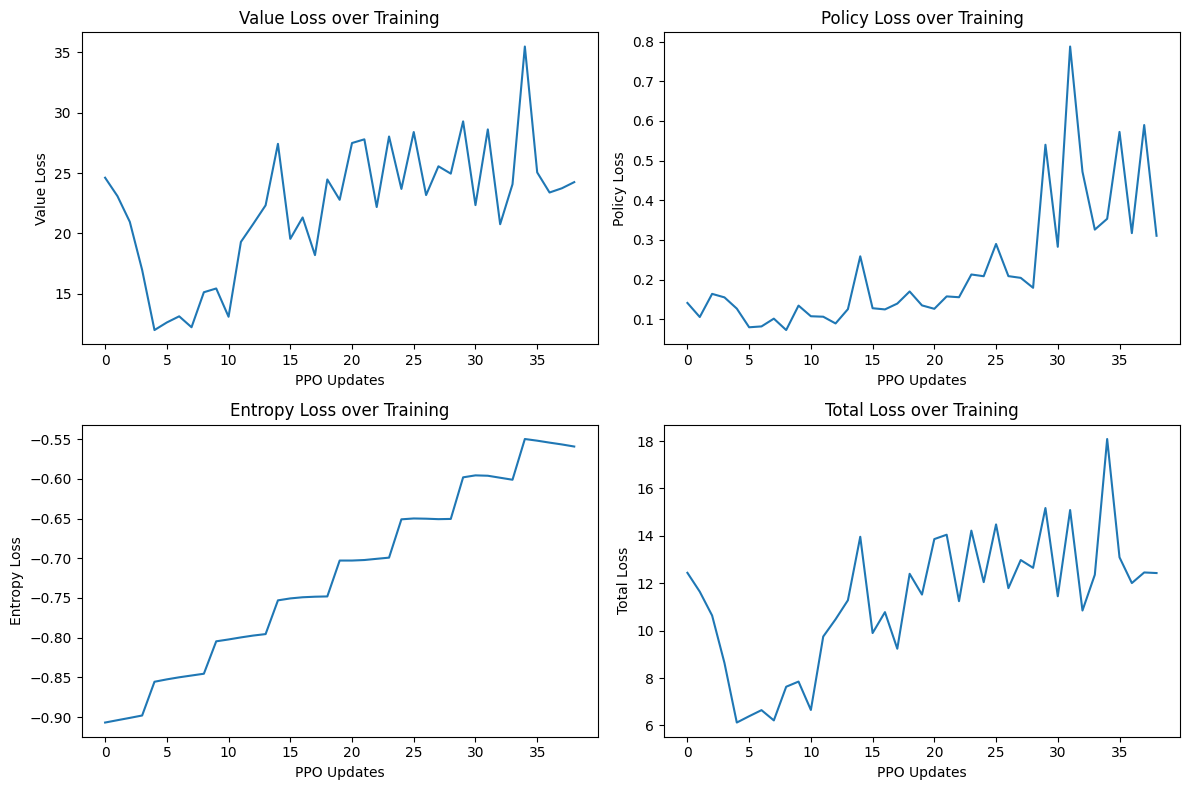

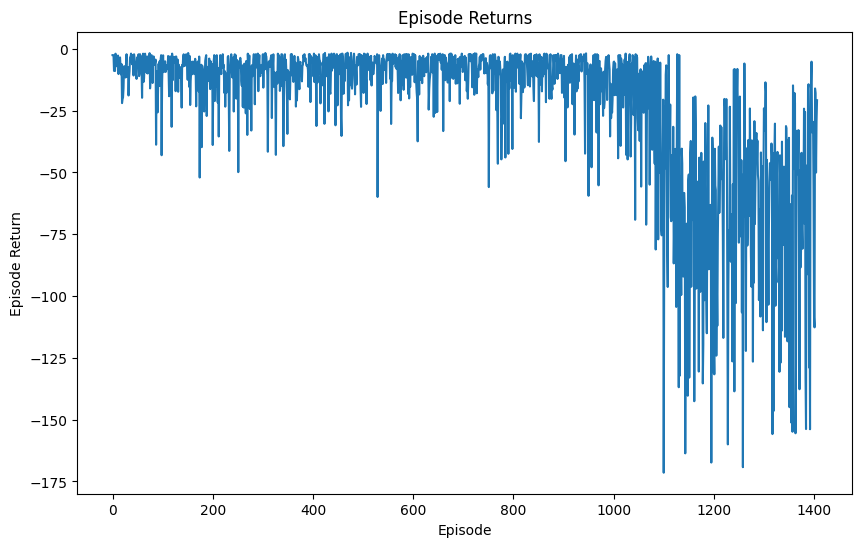

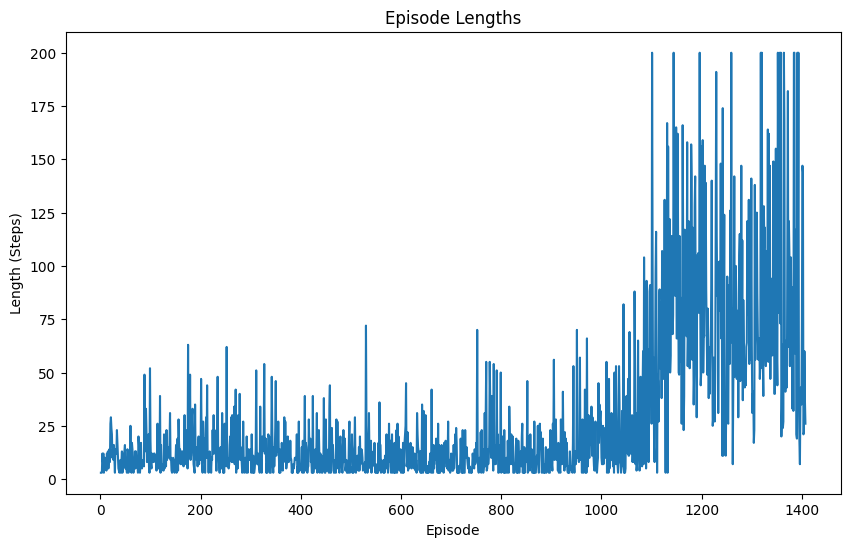

Final plots saved!


In [33]:
################################################################################
""" Initialization """
################################################################################
# Import additional libraries for video recording
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from IPython import display as ipythondisplay
import os
import torch
import math

# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [20, 10.0]       # s0, v0

# Setup the IDM Model for Longitudinal control
ego_vehicle_idm = IDM(desired_parameters, control_parameters)

# Environment Information
L = env.unwrapped.vehicle.LENGTH  # Length of vehicle for steering angle calculation

# Training Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# PPO Hyperparameters
hidden_dim            = 128  # Size of hidden layers
lr                    = 3e-4  # Learning rate
gamma                 = 0.99  # Discount factor
gae_lambda            = 0.95  # GAE lambda parameter
eps_clip              = 0.2  # PPO clipping parameter
value_coef            = 0.5  # Value loss coefficient
entropy_coef          = 0.01  # Entropy coefficient
k_epochs              = 10  # Number of PPO updates per batch
initial_action_std    = 0.6  # Initial action standard deviation
min_action_std        = 0.1  # Minimum action standard deviation
action_std_decay_rate = 0.05  # Action std decay rate
action_std_decay_freq = 5000  # Action std decay frequency in timesteps
max_grad_norm         = 0.5  # Maximum gradient norm for clipping

# Training Parameters
max_timesteps    = int(4e4)  # 40k total timesteps
update_timestep  = int(1024)  # Update policy every n timesteps
plot_freq_steps  = 5000  # Plot every 5000 timesteps
max_video_length = 500  # Maximum number of frames per video
episode_max_length = 200  # Maximum length of each episode

# Create directories for saved data
os.makedirs("training_plots", exist_ok=True)

# Reset environment and initialize state
obs, _ = env.reset()
state_manager = ENV(obs, 0.0)

# Initialize state information for IDM
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()
target_id = env.unwrapped.vehicle.lane_index[-1]
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)

# Initialize State Normalizer
normalizer = StateNormalizer(size=state_dim, device=device)
# Update the normalizer with initial state to start populating statistics
normalizer.update_from_dict(agent_state)

# Initialize PPO Agent
ppo_agent = PPOAgent(state_dim=state_dim, action_dim=1, hidden_dim=hidden_dim,
                    action_std_init=initial_action_std, device=device)
ppo_agent = ppo_agent.to(device)

# Initialize PPO Trainer
ppo_trainer = PPOTrainer(
    agent=ppo_agent,
    lr=lr,
    gamma=gamma,
    eps_clip=eps_clip,
    k_epochs=k_epochs,
    value_coef=value_coef,
    entropy_coef=entropy_coef
)

# Initialize PPO Memory
ppo_memory = PPOMemory()

# Function to decay action standard deviation
def decay_action_std(step, initial_std, min_std, decay_rate, decay_freq):
    """
    Decay the action standard deviation over time

    Args:
        step: Current timestep
        initial_std: Initial standard deviation
        min_std: Minimum standard deviation
        decay_rate: Decay rate
        decay_freq: Frequency of decay in timesteps

    Returns:
        current_std: Current standard deviation
    """
    # Calculate number of decay steps
    decay_steps = step // decay_freq

    # Calculate new std
    current_std = initial_std * (1 - decay_rate) ** decay_steps

    # Ensure minimum std
    current_std = max(current_std, min_std)

    return current_std


################################################################################
"""PPO Training Loop"""
################################################################################
print("Starting PPO training loop...")
print(f"Device: {device}, Update Timestep: {update_timestep}")
print(f"Learning Rate: {lr}, Gamma: {gamma}, GAE Lambda: {gae_lambda}")
print(f"PPO Clip: {eps_clip}, Value Coef: {value_coef}, Entropy Coef: {entropy_coef}")
print(f"K Epochs: {k_epochs}, Action STD: {initial_action_std}")
print(f"Max Timesteps: {max_timesteps}, Episode Max Length: {episode_max_length}")
print("=" * 80)

# Tracking variables
total_steps_taken = 0
episode_count = 0
avg_ep_length = 0
timestep_rewards = []
timestep_acce_rewards = []
timestep_rate_rewards = []
timestep_time_rewards = []
global_returns = []
loss_history = {'value_loss': [], 'policy_loss': [], 'entropy': [], 'total_loss': []}
timesteps_list = []
episode_lengths = []
episode_indices = []
episode_rewards_list = []

# Decay action std initially
current_action_std = initial_action_std

# Continue until we reach the maximum number of timesteps
while total_steps_taken < max_timesteps:
    episode_count += 1

    # Reset environment and state manager
    obs, _ = env.reset()
    state_manager = ENV(obs, 0.0)

    # Initial state information
    ego_state_idm = state_manager.ego_state_idm()
    lead_state = state_manager.longitudinal_lead_state()
    agent_state = state_manager.ego_state_agent(target_id=target_id)

    # Update normalizer with initial state
    normalizer.update_from_dict(agent_state)

    # Update IDM inputs based on initial state
    gap = lead_state['x']
    delta_velocity = lead_state['vx']
    input_variables = [gap, ego_state_idm['vx'], delta_velocity]

    episode_step = 0
    episode_return = 0.0
    done_flag = False

    # Track rewards for this episode specifically
    current_episode_rewards = []

    # Run until episode terminates or we hit max timesteps
    while not done_flag and total_steps_taken < max_timesteps:
        episode_step += 1
        total_steps_taken += 1
        timesteps_list.append(total_steps_taken)

        # Decay action std if it's time
        if total_steps_taken % action_std_decay_freq == 0:
            old_std = current_action_std
            current_action_std = decay_action_std(
                step=total_steps_taken,
                initial_std=initial_action_std,
                min_std=min_action_std,
                decay_rate=action_std_decay_rate,
                decay_freq=action_std_decay_freq
            )
            # Update the agent's action std if it changed
            if old_std != current_action_std:
                print(f"Decaying action std: {old_std:.4f} -> {current_action_std:.4f}")
                ppo_agent.set_action_std(current_action_std)

        ########################################################################
        """Action Selection"""
        ########################################################################
        # Determine target lane using gap controller
        gap_control = Gap_Controller(obs, following_gap_threshold=30)
        activated_target_lane = gap_control.lane_checker()

        # Set target lane id
        target_id = activated_target_lane
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        # Update the normalizer with the current state
        normalizer.update_from_dict(agent_state)

        # Get normalized state tensor
        state_tensor = normalizer.normalize_dict_to_tensor(agent_state)

        # Get action from PPO agent
        action, log_prob, value = ppo_agent.act(state_tensor)
        agent_action = action.item()  # Extract scalar value

        # Store observation for reward calculation
        obs_old = obs

        ########################################################################
        """Apply Action"""
        ########################################################################
        # IDM Longitudinal Control
        idm_acceleration = ego_vehicle_idm.longitudinal_controller(input_variables)
        longitudinal_control = idm_acceleration

        # Transform agent action to steering angle
        lateral_control = state_manager.steering_angle(agent_action, L)

        # Combine longitudinal and lateral actions
        action = [longitudinal_control, lateral_control]

        ########################################################################
        """Environment Step"""
        ########################################################################
        try:
            obs, reward, done, truncated, info = env.step(action)
            done_flag = done or truncated or episode_step >= episode_max_length or info['crashed'] or env.unwrapped.vehicle.on_road == False
        except Exception as e:
            print(f"Error during environment step: {e}")
            done_flag = True
            done = True
            reward = 0
            # Continue with default values for other variables
            break

        # Update state manager with new observation and applied longitudinal control
        state_manager = ENV(obs, longitudinal_control)

        # Compute reward based on the new state
        try:
            reward_components = state_manager.reward_function(obs_old, obs, target_id)
            reward = reward_components[0]
        except Exception as e:
            print(f"Error computing reward: {e}")
            reward_components = [0, 0, 0, 0]
            reward = 0

        # Add this reward to the current episode's rewards
        current_episode_rewards.append(reward)

        # Track rewards for each component
        timestep_rewards.append(reward)
        timestep_acce_rewards.append(reward_components[1])  # Acceleration reward
        timestep_rate_rewards.append(reward_components[2])  # Rate reward
        timestep_time_rewards.append(reward_components[3])  # Time reward

        # Update episode return
        episode_return += reward

        ########################################################################
        """Update State Information"""
        ########################################################################
        try:
            ego_state_idm = state_manager.ego_state_idm()
            lead_state = state_manager.longitudinal_lead_state()
            next_agent_state = state_manager.ego_state_agent(target_id=target_id)

            # Update the normalizer with the new state
            normalizer.update_from_dict(next_agent_state)

            # Update IDM variables
            gap = lead_state['x']
            delta_velocity = lead_state['vx']
            input_variables = [gap, ego_state_idm['vx'], delta_velocity]
        except Exception as e:
            print(f"Error updating state information: {e}")
            # Use default values if there's an error
            next_agent_state = agent_state

        ########################################################################
        """Store Experience in PPO Memory"""
        ########################################################################
        # Store experience in memory
        if log_prob is not None and value is not None:
            ppo_memory.add(
                state=agent_state,
                action=agent_action,
                reward=reward,
                done=float(done_flag),
                log_prob=log_prob.item(),
                value=value.item()
            )

        ########################################################################
        """PPO Update"""
        ########################################################################
        # Check if it's time to update the policy
        if ppo_memory.size() >= update_timestep:
            # Get the normalized next state to compute the final value
            next_state_tensor = normalizer.normalize_dict_to_tensor(next_agent_state)
            # Get the last state value
            with torch.no_grad():
                _, _, next_value = ppo_agent.act(next_state_tensor)
                next_value = next_value.item()

            # Get all data from memory
            states, actions, rewards, dones, log_probs, values = ppo_memory.get_all()

            # Compute GAE and returns
            advantages, returns = PPOTrainer.compute_gae(
                rewards=rewards,
                values=values,
                dones=dones,
                next_value=next_value,
                gamma=gamma,
                gae_lambda=gae_lambda
            )

            # Update PPO policy
            loss_info = ppo_trainer.update(
                states=states,
                actions=actions,
                log_probs=log_probs,
                returns=returns,
                advantages=advantages)

            # Store loss information
            for key in loss_info:
                loss_history[key].append(loss_info[key])

            # Print update information
            print(f"PPO Update at step {total_steps_taken} | "
                  f"Value Loss: {loss_info['value_loss']:.4f} | "
                  f"Policy Loss: {loss_info['policy_loss']:.4f} | "
                  f"Entropy: {loss_info['entropy']:.4f}")

            # Clear memory after update
            ppo_memory.clear()

        # Plot results based on timesteps
        if total_steps_taken % plot_freq_steps == 0 and total_steps_taken > 0:
            # Create plot directory if it doesn't exist
            plot_dir = "training_plots"
            if not os.path.exists(plot_dir):
                os.makedirs(plot_dir)

            # Plot reward components
            plt.figure(figsize=(12, 8))

            # Plot total rewards
            plt.subplot(2, 2, 1)
            plt.plot(timesteps_list, timestep_rewards)
            plt.xlabel("Timesteps")
            plt.ylabel("Total Reward")
            plt.title("Total Reward per Timestep")

            # Plot acceleration rewards
            plt.subplot(2, 2, 2)
            plt.plot(timesteps_list, timestep_acce_rewards)
            plt.xlabel("Timesteps")
            plt.ylabel("Acceleration Reward")
            plt.title("Acceleration Reward per Timestep")

            # Plot rate rewards
            plt.subplot(2, 2, 3)
            plt.plot(timesteps_list, timestep_rate_rewards)
            plt.xlabel("Timesteps")
            plt.ylabel("Rate Reward")
            plt.title("Rate Reward per Timestep")

            # Plot time rewards
            plt.subplot(2, 2, 4)
            plt.plot(timesteps_list, timestep_time_rewards)
            plt.xlabel("Timesteps")
            plt.ylabel("Time Reward")
            plt.title("Time Reward per Timestep")

            plt.tight_layout()
            plt.savefig(f"{plot_dir}/ppo_rewards_timestep_{total_steps_taken}.png")
            plt.show()
            plt.close()

            # Plot loss history if we have losses
            if len(loss_history['total_loss']) > 0:
                plt.figure(figsize=(12, 8))

                # Plot value loss
                plt.subplot(2, 2, 1)
                plt.plot(range(len(loss_history['value_loss'])), loss_history['value_loss'])
                plt.xlabel("PPO Updates")
                plt.ylabel("Value Loss")
                plt.title("Value Loss over Training")

                # Plot policy loss
                plt.subplot(2, 2, 2)
                plt.plot(range(len(loss_history['policy_loss'])), loss_history['policy_loss'])
                plt.xlabel("PPO Updates")
                plt.ylabel("Policy Loss")
                plt.title("Policy Loss over Training")

                # Plot entropy
                plt.subplot(2, 2, 3)
                plt.plot(range(len(loss_history['entropy'])), loss_history['entropy'])
                plt.xlabel("PPO Updates")
                plt.ylabel("Entropy Loss")
                plt.title("Entropy Loss over Training")

                # Plot total loss
                plt.subplot(2, 2, 4)
                plt.plot(range(len(loss_history['total_loss'])), loss_history['total_loss'])
                plt.xlabel("PPO Updates")
                plt.ylabel("Total Loss")
                plt.title("Total Loss over Training")

                plt.tight_layout()
                plt.savefig(f"{plot_dir}/ppo_loss_timestep_{total_steps_taken}.png")
                plt.show()
                plt.close()

            # Plot moving average of rewards (with window of 100)
            if len(timestep_rewards) > 100:
                plt.figure(figsize=(10, 6))
                window_size = 100
                moving_avg = np.convolve(timestep_rewards, np.ones(window_size)/window_size, mode='valid')
                plt.plot(range(len(moving_avg)), moving_avg)
                plt.xlabel("Timesteps")
                plt.ylabel(f"Average Reward (Window={window_size})")
                plt.title(f"Moving Average Reward (Window={window_size})")
                plt.savefig(f"{plot_dir}/ppo_moving_avg_reward_timestep_{total_steps_taken}.png")
                plt.show()
                plt.close()

            # Plot episode lengths if we have episodes
            if len(episode_lengths) > 0:
                plt.figure(figsize=(10, 6))
                plt.plot(episode_indices, episode_lengths)
                plt.xlabel("Episode")
                plt.ylabel("Length (Steps)")
                plt.title("Episode Lengths")
                plt.savefig(f"{plot_dir}/ppo_episode_lengths_{total_steps_taken}.png")
                plt.show()
                plt.close()

            print(f"Plots saved at timestep {total_steps_taken}")

    # Data Collection
    global_returns.append(episode_return)
    episode_lengths.append(episode_step)
    episode_indices.append(episode_count)

    # Store this episode's rewards
    if len(current_episode_rewards) > 0:
        episode_rewards_list.append(current_episode_rewards)

    # Calculate average episode length
    avg_ep_length = np.mean(episode_lengths[-100:]) if len(episode_lengths) >= 100 else np.mean(episode_lengths)

    # Get average return from recent episodes
    avg_return = np.mean(global_returns[-100:]) if len(global_returns) >= 100 else np.mean(global_returns)

    # Get most recent loss values if available
    if len(loss_history['total_loss']) > 0:
        last_value_loss = loss_history['value_loss'][-1]
        last_policy_loss = loss_history['policy_loss'][-1]
    else:
        last_value_loss = "N/A"
        last_policy_loss = "N/A"

    # Calculate average and standard deviation of reward per timestep for this episode
    if len(current_episode_rewards) > 0:
        avg_reward_per_step = np.mean(current_episode_rewards)
        std_reward_per_step = np.std(current_episode_rewards)
        reward_stats = f"Reward/Step: {avg_reward_per_step:.3f}±{std_reward_per_step:.3f}"
    else:
        reward_stats = "Reward/Step: N/A"

    # Print the progress report with enhanced statistics
    print(f"Ep {episode_count:3d} | Steps: {episode_step:4d} | Avg Ep Len: {avg_ep_length:.1f} | Total Steps: {total_steps_taken:5d}/{max_timesteps} | "
          f"Ep Return: {episode_return:6.2f} | Avg Return: {avg_return:6.2f} | {reward_stats} | "
          f"Action STD: {current_action_std:.3f}")

# Final plots after training is complete
print("\nTraining complete! Creating final plots...")

# Plot all rewards in separate figures if we have data
if len(timesteps_list) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(timesteps_list, timestep_rewards)
    plt.xlabel("Timesteps")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Timestep")
    plt.savefig("ppo_final_total_rewards.png")
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps_list, timestep_acce_rewards)
    plt.xlabel("Timesteps")
    plt.ylabel("Acceleration Reward")
    plt.title("Acceleration Reward per Timestep")
    plt.savefig("ppo_final_acce_rewards.png")
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps_list, timestep_rate_rewards)
    plt.xlabel("Timesteps")
    plt.ylabel("Rate Reward")
    plt.title("Rate Reward per Timestep")
    plt.savefig("ppo_final_rate_rewards.png")
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps_list, timestep_time_rewards)
    plt.xlabel("Timesteps")
    plt.ylabel("Time Reward")
    plt.title("Time Reward per Timestep")
    plt.savefig("ppo_final_time_rewards.png")
    plt.show()
    plt.close()

# Plot loss history if we have losses
if len(loss_history['total_loss']) > 0:
    plt.figure(figsize=(12, 8))

    # Plot all losses in subplots
    plt.subplot(2, 2, 1)
    plt.plot(range(len(loss_history['value_loss'])), loss_history['value_loss'])
    plt.xlabel("PPO Updates")
    plt.ylabel("Value Loss")
    plt.title("Value Loss over Training")

    plt.subplot(2, 2, 2)
    plt.plot(range(len(loss_history['policy_loss'])), loss_history['policy_loss'])
    plt.xlabel("PPO Updates")
    plt.ylabel("Policy Loss")
    plt.title("Policy Loss over Training")

    plt.subplot(2, 2, 3)
    plt.plot(range(len(loss_history['entropy'])), loss_history['entropy'])
    plt.xlabel("PPO Updates")
    plt.ylabel("Entropy Loss")
    plt.title("Entropy Loss over Training")

    plt.subplot(2, 2, 4)
    plt.plot(range(len(loss_history['total_loss'])), loss_history['total_loss'])
    plt.xlabel("PPO Updates")
    plt.ylabel("Total Loss")
    plt.title("Total Loss over Training")

    plt.tight_layout()
    plt.savefig("ppo_final_losses.png")
    plt.show()
    plt.close()

# Plot episode returns
if len(global_returns) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(global_returns)), global_returns)
    plt.xlabel("Episode")
    plt.ylabel("Episode Return")
    plt.title("Episode Returns")
    plt.savefig("ppo_final_episode_returns.png")
    plt.show()
    plt.close()

# Plot episode lengths
if len(episode_lengths) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(episode_indices, episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Length (Steps)")
    plt.title("Episode Lengths")
    plt.savefig("ppo_final_episode_lengths.png")
    plt.show()
    plt.close()

print("Final plots saved!")

Test

In [34]:
################################################################################
""" Testing and Visualization of Trained PPO Agent """
################################################################################
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython import display as ipythondisplay
import base64
import io
import glob
import os
from gymnasium.wrappers import RecordVideo
from datetime import datetime

# Create directories for saved videos and evaluation metrics
os.makedirs("test_videos", exist_ok=True)
os.makedirs("evaluation_results", exist_ok=True)

# Load the trained model
print("Loading trained PPO agent...")
model_path = "ppo_agent_final.pth"  # Update this to match your saved model path

# If you have a saved model, load it here
# Otherwise, we'll use the agent from the training session (assuming it exists)
if os.path.exists(model_path):
    # Load the trained agent
    ppo_agent.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded from {model_path}")
else:
    print("No saved model found, using the agent from training.")
    # If you're running this right after training, the ppo_agent should still be in memory
    # Otherwise, you'll need to initialize a new agent with the same parameters as your trained model

# Test configuration
num_test_episodes = 10  # Number of test episodes to run
render_mode = "rgb_array"  # Use "rgb_array" for recording, "human" for display
max_test_steps = 500  # Maximum steps per test episode
record_video = True  # Whether to record video of the tests

# Create a video recording environment
def create_test_env(env, record=True):
    """Create a test environment with video recording if requested"""
    if record:
        # Current timestamp for unique video naming
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        video_path = f"./test_videos/{timestamp}"
        os.makedirs(video_path, exist_ok=True)

        # Wrap environment with RecordVideo
        env = RecordVideo(
            env,
            video_folder=video_path,
            episode_trigger=lambda x: True,  # Record every episode
            name_prefix="lane_change_agent"
        )
    return env

# Function to show video
def show_video(video_path):
    """Display a video recording in the notebook"""
    mp4list = glob.glob(os.path.join(video_path, '*.mp4'))
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''
            <video width="640" height="480" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4">
            </video>'''.format(encoded.decode('ascii'))))
    else:
        print("No video found at", video_path)

# Test statistics tracking
episode_rewards = []
episode_success_rates = []
episode_collision_rates = []
lane_change_times = []
completed_changes = []

################################################################################
""" Testing Loop """
################################################################################
print(f"Starting testing of PPO agent over {num_test_episodes} episodes...")

# Prepare test environment
test_env = env  # Use the same environment object from training or create a new one
if record_video:
    test_env = create_test_env(test_env, record=True)

# Set agent to evaluation mode
ppo_agent.eval()

for episode in range(num_test_episodes):
    print(f"\nStarting test episode {episode+1}/{num_test_episodes}")

    # Reset environment
    obs, _ = test_env.reset()
    state_manager = ENV(obs, 0.0)

    # Initialize episode variables
    total_reward = 0
    step_count = 0
    lane_changes_attempted = 0
    lane_changes_completed = 0
    collisions = 0
    change_start_time = None
    initial_lane = env.unwrapped.vehicle.lane_index[-1]
    current_lane = initial_lane

    # Track successful lane changes
    lane_change_in_progress = False
    lane_change_start_step = 0

    # Keep track of all rewards for plotting
    step_rewards = []

    # Run the episode
    done = False
    while not done and step_count < max_test_steps:
        step_count += 1

        # Determine target lane
        gap_control = Gap_Controller(obs, following_gap_threshold=30)
        target_id = gap_control.lane_checker()

        # If target lane is different from current, we're attempting a lane change
        if target_id != current_lane and not lane_change_in_progress:
            lane_changes_attempted += 1
            lane_change_in_progress = True
            lane_change_start_step = step_count
            print(f"Lane change attempted at step {step_count}: {current_lane} -> {target_id}")

        # Get agent state
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        # Normalize state
        state_tensor = normalizer.normalize_dict_to_tensor(agent_state)

        # Get action from agent (no need to store log_prob or value in testing)
        with torch.no_grad():
            action, _, _ = ppo_agent.act(state_tensor)
            agent_action = action.item()

        # Store observation for reward calculation
        obs_old = obs

        # Get IDM control (longitudinal)
        ego_state_idm = state_manager.ego_state_idm()
        lead_state = state_manager.longitudinal_lead_state()
        gap = lead_state['x']
        delta_velocity = lead_state['vx']
        input_variables = [gap, ego_state_idm['vx'], delta_velocity]
        idm_acceleration = ego_vehicle_idm.longitudinal_controller(input_variables)

        # Transform agent action to steering angle (lateral)
        lateral_control = state_manager.steering_angle(agent_action, L)

        # Apply action
        action = [idm_acceleration, lateral_control]
        obs, reward, done, truncated, info = test_env.step(action)

        # Update state manager
        state_manager = ENV(obs, idm_acceleration)

        # Calculate reward
        reward_components = state_manager.reward_function(obs_old, obs, target_id)
        reward = reward_components[0]
        total_reward += reward
        step_rewards.append(reward)

        # Check lane change completion
        new_lane = env.unwrapped.vehicle.lane_index[-1]
        if new_lane != current_lane:
            current_lane = new_lane
            if lane_change_in_progress:
                lane_changes_completed += 1
                lane_change_duration = step_count - lane_change_start_step
                lane_change_times.append(lane_change_duration)
                lane_change_in_progress = False
                print(f"Lane change completed at step {step_count} (took {lane_change_duration} steps)")

        # Check for collisions
        if info.get('crashed', False):
            collisions += 1
            print(f"Collision detected at step {step_count}")
            # Could break here if you want to stop on collision

        # Break if done or truncated
        if done or truncated:
            print(f"Episode ended at step {step_count}: done={done}, truncated={truncated}")
            break

    # End of episode - collect statistics
    episode_rewards.append(total_reward)
    success_rate = lane_changes_completed / max(lane_changes_attempted, 1)
    episode_success_rates.append(success_rate)
    collision_rate = collisions / max(step_count, 1)
    episode_collision_rates.append(collision_rate)
    completed_changes.append(lane_changes_completed)

    # Print episode summary
    print(f"Episode {episode+1} Summary:")
    print(f"  Steps: {step_count}")
    print(f"  Total Reward: {total_reward:.2f}")
    print(f"  Lane Changes Attempted: {lane_changes_attempted}")
    print(f"  Lane Changes Completed: {lane_changes_completed}")
    print(f"  Success Rate: {success_rate:.2f}")
    print(f"  Collisions: {collisions}")

    # Plot rewards for this episode
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(step_rewards)), step_rewards)
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.title(f"Test Episode {episode+1} Rewards")
    plt.savefig(f"evaluation_results/test_episode_{episode+1}_rewards.png")
    plt.close()

    # Display video if recorded
    if record_video:
        # Find the most recent video
        video_folders = sorted(glob.glob("./test_videos/*"))
        if video_folders:
            latest_folder = video_folders[-1]
            print(f"Displaying video from {latest_folder}")
            show_video(latest_folder)

# Final evaluation statistics
print("\n" + "="*50)
print("TESTING COMPLETE - FINAL EVALUATION")
print("="*50)
print(f"Average Episode Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
print(f"Average Success Rate: {np.mean(episode_success_rates):.2f} ± {np.std(episode_success_rates):.2f}")
print(f"Average Collision Rate: {np.mean(episode_collision_rates):.2f} ± {np.std(episode_collision_rates):.2f}")
print(f"Average Lane Changes Completed: {np.mean(completed_changes):.2f} ± {np.std(completed_changes):.2f}")

if len(lane_change_times) > 0:
    print(f"Average Lane Change Time: {np.mean(lane_change_times):.2f} ± {np.std(lane_change_times):.2f} steps")

# Create final evaluation plots
# Success Rate vs Episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_test_episodes+1), episode_success_rates, marker='o')
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Lane Change Success Rate by Episode")
plt.ylim(0, 1.1)
plt.grid(True)
plt.savefig("evaluation_results/success_rate_by_episode.png")
plt.close()

# Collision Rate vs Episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_test_episodes+1), episode_collision_rates, marker='o', color='r')
plt.xlabel("Episode")
plt.ylabel("Collision Rate")
plt.title("Collision Rate by Episode")
plt.ylim(0, max(max(episode_collision_rates) * 1.1, 0.1))
plt.grid(True)
plt.savefig("evaluation_results/collision_rate_by_episode.png")
plt.close()

# Total Reward vs Episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_test_episodes+1), episode_rewards, marker='o', color='g')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward by Episode")
plt.grid(True)
plt.savefig("evaluation_results/total_reward_by_episode.png")
plt.close()

# Lane Changes Completed vs Episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_test_episodes+1), completed_changes, marker='o', color='purple')
plt.xlabel("Episode")
plt.ylabel("Lane Changes Completed")
plt.title("Lane Changes Completed by Episode")
plt.grid(True)
plt.savefig("evaluation_results/lane_changes_by_episode.png")
plt.close()

# Distribution of Lane Change Times (if we have any)
if len(lane_change_times) > 0:
    plt.figure(figsize=(10, 6))
    plt.hist(lane_change_times, bins=10, color='blue', alpha=0.7)
    plt.axvline(np.mean(lane_change_times), color='r', linestyle='dashed', linewidth=2,
                label=f'Mean: {np.mean(lane_change_times):.2f} steps')
    plt.xlabel("Steps to Complete Lane Change")
    plt.ylabel("Frequency")
    plt.title("Distribution of Lane Change Times")
    plt.legend()
    plt.grid(True)
    plt.savefig("evaluation_results/lane_change_time_distribution.png")
    plt.close()

print("\nEvaluation plots saved to 'evaluation_results' folder")
print("Testing completed!")

# Optionally, save a custom demo video of the best-performing episode
# This would require tracking the best episode and recording it separately

Loading trained PPO agent...
No saved model found, using the agent from training.
Starting testing of PPO agent over 10 episodes...

Starting test episode 1/10


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/test_videos/20250509_102043 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Lane change attempted at step 101: 1 -> 0
Lane change completed at step 105 (took 4 steps)
Lane change attempted at step 106: 2 -> 1
Lane change completed at step 107 (took 1 steps)
Lane change attempted at step 108: 1 -> 0
Lane change completed at step 117 (took 9 steps)
Lane change attempted at step 119: 1 -> 0
Lane change completed at step 123 (took 4 steps)
Lane change attempted at step 165: 1 -> 0
Lane change completed at step 167 (took 2 steps)
Lane change attempted at step 169: 1 -> 0
Lane change completed at step 178 (took 9 steps)
Lane change attempted at step 182: 1 -> 0
Lane change completed at step 182 (took 0 steps)
Lane change attempted at step 186: 1 -> 0
Lane change completed at step 188 (took 2 steps)
Lane change attempted at step 193: 1 -> 0
Lane change completed at step 197 (took 4 steps)
Lane change attempted at step 199: 1 -> 0
Lane change completed at step 203 (took 4 steps)
Lane change attempted at step 213: 1 -> 0
Lane change completed at step 214 (took 1 steps)


Starting test episode 3/10
Lane change attempted at step 1: 2 -> 1
Lane change completed at step 42 (took 41 steps)
Lane change attempted at step 43: 1 -> 0
Lane change completed at step 45 (took 2 steps)
Lane change attempted at step 46: 2 -> 1
Lane change completed at step 46 (took 0 steps)
Lane change attempted at step 47: 1 -> 0
Lane change completed at step 49 (took 2 steps)
Lane change attempted at step 50: 2 -> 1
Lane change completed at step 50 (took 0 steps)
Lane change attempted at step 51: 1 -> 0
Lane change completed at step 51 (took 0 steps)
Lane change attempted at step 52: 2 -> 1
Lane change completed at step 53 (took 1 steps)
Lane change attempted at step 54: 1 -> 0
Lane change completed at step 55 (took 1 steps)
Lane change attempted at step 56: 2 -> 1
Lane change completed at step 57 (took 1 steps)
Lane change attempted at step 58: 1 -> 0
Lane change completed at step 59 (took 1 steps)
Lane change attempted at step 60: 2 -> 1
Lane change completed at step 71 (took 11


Starting test episode 4/10
Lane change attempted at step 1: 1 -> 0
Lane change completed at step 6 (took 5 steps)
Lane change attempted at step 7: 2 -> 1
Lane change completed at step 21 (took 14 steps)
Lane change attempted at step 22: 1 -> 0
Lane change completed at step 22 (took 0 steps)
Lane change attempted at step 23: 2 -> 1
Lane change completed at step 30 (took 7 steps)
Lane change attempted at step 31: 1 -> 0
Lane change completed at step 43 (took 12 steps)
Lane change attempted at step 44: 2 -> 1
Lane change completed at step 48 (took 4 steps)
Lane change attempted at step 49: 1 -> 0
Lane change completed at step 51 (took 2 steps)
Lane change attempted at step 60: 1 -> 2
Lane change completed at step 60 (took 0 steps)
Lane change attempted at step 64: 1 -> 2
Lane change completed at step 68 (took 4 steps)
Lane change attempted at step 77: 1 -> 2
Lane change completed at step 78 (took 1 steps)
Lane change attempted at step 83: 1 -> 2
Lane change completed at step 85 (took 2 s


Starting test episode 5/10
Collision detected at step 59
Episode ended at step 59: done=True, truncated=False
Episode 5 Summary:
  Steps: 59
  Total Reward: -44.42
  Lane Changes Attempted: 0
  Lane Changes Completed: 0
  Success Rate: 0.00
  Collisions: 1
Displaying video from ./test_videos/20250509_102043



Starting test episode 6/10
Lane change attempted at step 16: 1 -> 2
Lane change completed at step 16 (took 0 steps)
Lane change attempted at step 21: 2 -> 1
Lane change completed at step 212 (took 191 steps)
Lane change attempted at step 213: 1 -> 2
Lane change completed at step 216 (took 3 steps)
Lane change attempted at step 217: 0 -> 1
Lane change completed at step 372 (took 155 steps)
Lane change attempted at step 387: 0 -> 1
Lane change completed at step 388 (took 1 steps)
Lane change attempted at step 399: 0 -> 1
Episode ended at step 400: done=False, truncated=True
Episode 6 Summary:
  Steps: 400
  Total Reward: -251.15
  Lane Changes Attempted: 6
  Lane Changes Completed: 5
  Success Rate: 0.83
  Collisions: 0
Displaying video from ./test_videos/20250509_102043



Starting test episode 7/10
Lane change attempted at step 11: 2 -> 1
Lane change completed at step 35 (took 24 steps)
Lane change attempted at step 37: 2 -> 1
Lane change completed at step 51 (took 14 steps)
Lane change attempted at step 53: 2 -> 1
Lane change completed at step 60 (took 7 steps)
Lane change attempted at step 63: 2 -> 1
Lane change completed at step 68 (took 5 steps)
Lane change attempted at step 76: 2 -> 1
Lane change completed at step 77 (took 1 steps)
Lane change attempted at step 79: 2 -> 1
Lane change completed at step 84 (took 5 steps)
Lane change attempted at step 96: 2 -> 1
Lane change completed at step 97 (took 1 steps)
Lane change attempted at step 113: 2 -> 1
Lane change completed at step 113 (took 0 steps)
Lane change attempted at step 118: 2 -> 1
Lane change completed at step 123 (took 5 steps)
Lane change attempted at step 128: 2 -> 1
Lane change completed at step 129 (took 1 steps)
Lane change attempted at step 144: 2 -> 1
Lane change completed at step 14


Starting test episode 8/10
Lane change attempted at step 1: 2 -> 1
Lane change completed at step 21 (took 20 steps)
Lane change attempted at step 22: 1 -> 0
Lane change completed at step 23 (took 1 steps)
Lane change attempted at step 25: 1 -> 0
Lane change completed at step 31 (took 6 steps)
Lane change attempted at step 34: 1 -> 2
Lane change completed at step 34 (took 0 steps)
Lane change attempted at step 36: 1 -> 2
Lane change completed at step 36 (took 0 steps)
Lane change attempted at step 37: 0 -> 1
Lane change completed at step 65 (took 28 steps)
Lane change attempted at step 66: 1 -> 0
Lane change completed at step 68 (took 2 steps)
Lane change attempted at step 76: 1 -> 0
Collision detected at step 76
Episode ended at step 76: done=True, truncated=False
Episode 8 Summary:
  Steps: 76
  Total Reward: -55.53
  Lane Changes Attempted: 8
  Lane Changes Completed: 7
  Success Rate: 0.88
  Collisions: 1
Displaying video from ./test_videos/20250509_102043



Starting test episode 9/10
Lane change attempted at step 9: 2 -> 1
Collision detected at step 118
Episode ended at step 118: done=True, truncated=False
Episode 9 Summary:
  Steps: 118
  Total Reward: -93.06
  Lane Changes Attempted: 1
  Lane Changes Completed: 0
  Success Rate: 0.00
  Collisions: 1
Displaying video from ./test_videos/20250509_102043



Starting test episode 10/10
Lane change attempted at step 197: 2 -> 1
Lane change completed at step 199 (took 2 steps)
Collision detected at step 231
Episode ended at step 231: done=True, truncated=False
Episode 10 Summary:
  Steps: 231
  Total Reward: -184.18
  Lane Changes Attempted: 1
  Lane Changes Completed: 1
  Success Rate: 1.00
  Collisions: 1
Displaying video from ./test_videos/20250509_102043



TESTING COMPLETE - FINAL EVALUATION
Average Episode Reward: -189.59 ± 88.02
Average Success Rate: 0.76 ± 0.38
Average Collision Rate: 0.00 ± 0.01
Average Lane Changes Completed: 19.60 ± 18.33
Average Lane Change Time: 5.51 ± 18.37 steps

Evaluation plots saved to 'evaluation_results' folder
Testing completed!
